<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro)**

В этом домашнем задании вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;
* реализовать веб-сервис для применения построенной модели на новых данных

> Оценка за домашку = $min(\text{ваш балл}, 11)$

**Мягкий дедлайн: 27 ноября 23:59**

**Жесткий дедлайн: 20 декабря 23:59 (конец модуля)**



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('inline')

import random
import seaborn as sns
from ydata_profiling import ProfileReport
import os
import joblib
import re
from math import log

# Анализ корреляции
import phik
from phik.report import plot_correlation_matrix

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

# Метрики
from sklearn.metrics import r2_score, mean_squared_error as MSE

# Создание пайплайна
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# Масштабирование и кодирование признаков
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Подбор гиперпараметров
from sklearn.model_selection import GridSearchCV

# Перебор наборов признаков
from itertools import combinations

random.seed(42)
np.random.seed(42)

DATA_PATH = '../data/'
MODEL_PATH = '../models/'

### **Задание 0**
Для чего фиксируем сиды в домашках?

`Сиды фиксируем для воспроизводимости результатов при повторных запусках`

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [x] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [x] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [x] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [x] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла)

#### Общие сведения

In [3]:
# Посмотрим общие сведения о данных
# Обучающая выборка
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6999 non-null   object 
 1   year           6999 non-null   int64  
 2   selling_price  6999 non-null   int64  
 3   km_driven      6999 non-null   int64  
 4   fuel           6999 non-null   object 
 5   seller_type    6999 non-null   object 
 6   transmission   6999 non-null   object 
 7   owner          6999 non-null   object 
 8   mileage        6797 non-null   object 
 9   engine         6797 non-null   object 
 10  max_power      6803 non-null   object 
 11  torque         6796 non-null   object 
 12  seats          6797 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 711.0+ KB


In [4]:
# Тестовая выборка
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           1000 non-null   object 
 1   year           1000 non-null   int64  
 2   selling_price  1000 non-null   int64  
 3   km_driven      1000 non-null   int64  
 4   fuel           1000 non-null   object 
 5   seller_type    1000 non-null   object 
 6   transmission   1000 non-null   object 
 7   owner          1000 non-null   object 
 8   mileage        981 non-null    object 
 9   engine         981 non-null    object 
 10  max_power      981 non-null    object 
 11  torque         981 non-null    object 
 12  seats          981 non-null    float64
dtypes: float64(1), int64(3), object(9)
memory usage: 101.7+ KB


In [5]:
# Посмотрим первые строки
# Обучающая выборка
df_train.head()

name  year  selling_price  km_driven    fuel  \
0         Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1   Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
3         Maruti Swift VXI BSIII  2007         130000     120000  Petrol   
4  Hyundai Xcent 1.2 VTVT E Plus  2017         440000      45000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
3  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   
4  Individual       Manual   First Owner  20.14 kmpl  1197 CC   81.86 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250Nm@ 1500-2500rpm    5.0  
2  22.4 kgm at 1750-2750rpm    5.0  
3     11.5@ 4,500(kgm@ rpm)    5.0  
4         113.75nm@ 4000rpm    5.0

In [6]:
# Тестовая выборка
df_test.head()

name  year  selling_price  km_driven  \
0                  Mahindra Xylo E4 BS IV  2010         229999     168000   
1              Tata Nexon 1.5 Revotorq XE  2017         665000      25000   
2                    Honda Civic 1.8 S AT  2007         175000     218463   
3                    Honda City i DTEC VX  2015         635000     173000   
4  Tata Indica Vista Aura 1.2 Safire BSIV  2011         130000      70000   

     fuel seller_type transmission         owner    mileage   engine  \
0  Diesel  Individual       Manual   First Owner  14.0 kmpl  2498 CC   
1  Diesel  Individual       Manual   First Owner  21.5 kmpl  1497 CC   
2  Petrol  Individual    Automatic   First Owner  12.9 kmpl  1799 CC   
3  Diesel  Individual       Manual   First Owner  25.1 kmpl  1498 CC   
4  Petrol  Individual       Manual  Second Owner  16.5 kmpl  1172 CC   

   max_power                   torque  seats  
0    112 bhp  260 Nm at 1800-2200 rpm    7.0  
1  108.5 bhp      260Nm@ 1500-2750rpm    5.0  
2    130 bhp           172Nm@ 4300rpm    5.0  
3   98.6 bhp           200Nm@ 1750rpm    5.0  
4     65 bhp     96  Nm at 3000  rpm     5.0

Видим, что в выборках содержатся колонки:
- `name	` - наименование автомобиля,
- `year	` - год выпуска,
- `selling_price` - цена,
- `km_driven` - пробег (км),
- `fuel` - вид топлива,
- `seller_type` - тип продавца,
- `transmission` - тип коробки передач,
- `owner` - информация о владельце,
- `mileage` - информация о расходе топлива (км на 1 л),
- `engine` - объём двигателя ($см^3$),
- `max_power` - максимальная мощность (brake horsepower, лошадиные силы),
- `torque` - информация о максимальном крутящем моменте ($Н \cdot м$) и оборотах, при которых он достигается ($мин^{-1}$),
- `seats` - количество мест.

#### Типы

Видим, что признак `mileage`, `engine`,  `max_power` представлены не только своими значениями, к значению добавлена единица измерения. Уберём единицы измерений из указанных столбцов, чтоб остались только значения. В столбце `torque` представлено два значения (крутящий момент и обороты, при которых достигается момент). Разобъём столбец на два, чтоб в одном столбце был представлен момент, а в другом - обороты, при которых достигается такой момент.

In [7]:
# Уберём единицы измерения из столбцов `mileage`, `engine`, `max_power`
for col in ['mileage', 'engine', 'max_power']:
    # В обучающей выборке
    df_train.loc[~df_train[col].isna(), col] = \
    df_train[~df_train[col].isna()][col].str.split().apply(
        lambda x: float(x[0]) if len(x) == 2 else np.nan)
    df_train[col] = df_train[col].astype('float')

    # В тестовой выборке
    df_test.loc[~df_test[col].isna(), col] = \
    df_test[~df_test[col].isna()][col].str.split().apply(
        lambda x: float(x[0]) if len(x) == 2 else np.nan)
    df_test[col] = df_test[col].astype('float')

In [8]:
# Определим функцию для выделения значений момента
def get_torque(torq_text):

    # Приведём текст к нижнему регистру
    torq_text = torq_text.lower()

    # Выделим значения с помощью регулярных выражений
    # Паттерн для выделения значений момента или скорости
    pattern_digits = r"[0-9,\.]{1,}"
    obtained_values = re.findall(pattern_digits, torq_text)

    # Паттерн для выделения единиц измерения
    pattern_units = r"[kgmrpn]{2,}"
    obtained_units = re.findall(pattern_units, torq_text)

    if len(obtained_units) == 0:
        return float(obtained_values[0])
    elif len(obtained_units) == 1:
        if obtained_units[0] == 'rpm' or obtained_units[0] == 'nm':
            return float(obtained_values[0])
        else:
            # Приведём кгм к Нм
            return float(obtained_values[0]) * 9.80665
    elif len(obtained_units) == 2:
        if obtained_units[0] == 'nm':
            return float(obtained_values[0])
        else:
            # Приведём кгм к Нм
            return float(obtained_values[0]) * 9.80665
    else:
        return float(obtained_values[0])

In [9]:
# Определим функцию для выделения значений оборотов
def get_speed(torq_text):

    # Приведём текст к нижнему регистру
    torq_text = torq_text.lower()

    # Выделим значения с помощью регулярных выражений
    # Паттерн для выделения значений момента или скорости
    pattern_digits = r"[0-9,\.]{1,}"
    obtained_values = re.findall(pattern_digits, torq_text)

    # Паттерн для выделения единиц измерения
    pattern_units = r"[kgmrpn]{2,}"
    obtained_units = re.findall(pattern_units, torq_text)

    if len(obtained_units) in [0, 1, 2]:
        # Возвращаем значение скорости
        if len(obtained_values) == 2:
            return float(obtained_values[1].replace(',', ''))
        # Если два значения скорости, то вернём среднее
        if len(obtained_values) == 3:
            if float(obtained_values[2].replace(',', '')) > float(obtained_values[1].replace(',', '')):
                return 0.5 * (float(obtained_values[1].replace(',', '')) + \
                          float(obtained_values[2].replace(',', '')))
            else:
                return float(obtained_values[1].replace(',', ''))
    else:
        return float(obtained_values[2].replace(',', ''))

In [10]:
# Получим значение скорости
df_train.loc[~df_train['torque'].isna(), 'max_torque_rpm'] = \
df_train[~df_train['torque'].isna()]['torque'].apply(get_speed)

# Получим значение максимального крутящего момента
df_train.loc[~df_train['torque'].isna(), 'torque'] = \
df_train[~df_train['torque'].isna()]['torque'].apply(get_torque)
df_train['torque'] = df_train['torque'].astype('float')

In [11]:
# Аналогично проделаем для тестовой выборки
df_test.loc[~df_test['torque'].isna(), 'max_torque_rpm'] = \
df_test[~df_test['torque'].isna()]['torque'].apply(get_speed)

# Получим значение максимального крутящего момента
df_test.loc[~df_test['torque'].isna(), 'torque'] = \
df_test[~df_test['torque'].isna()]['torque'].apply(get_torque)
df_test['torque'] = df_test['torque'].astype('float')

#### Пропуски

In [12]:
# Посмотрим количество пропусков
pd.concat(
    [df_train.isna().sum(), df_train.isna().mean()],
    axis=1
).rename(
    columns = { 0: 'train_count', 1: 'train_part' }
).merge(
    pd.concat(
    [df_test.isna().sum(), df_test.isna().mean()],
    axis=1
).rename(
    columns = { 0: 'test_count', 1: 'test_part' }
),
    how='left',
    left_index=True,
    right_index=True,
    validate='1:1'
)

train_count  train_part  test_count  test_part
name                      0    0.000000           0      0.000
year                      0    0.000000           0      0.000
selling_price             0    0.000000           0      0.000
km_driven                 0    0.000000           0      0.000
fuel                      0    0.000000           0      0.000
seller_type               0    0.000000           0      0.000
transmission              0    0.000000           0      0.000
owner                     0    0.000000           0      0.000
mileage                 202    0.028861          19      0.019
engine                  202    0.028861          19      0.019
max_power               203    0.029004          19      0.019
torque                  203    0.029004          19      0.019
seats                   202    0.028861          19      0.019
max_torque_rpm          231    0.033005          23      0.023

Видим, что имеются пропуски в колонках:
- `mileage` - информация о расходе топлива (км на 1 л),
- `engine` - объём двигателя ($см^3$),
- `max_power` - максимальная мощность (brake horsepower, лошадиные силы),
- `torque` - информация о максимальном крутящем моменте ($Н \cdot м$),
- `seats` - количество мест,
- `max_torque_rpm` - оборотах, при которых достигается максимальный крутящий момент ($мин^{-1}$).

Обработку пропусков выполним далее.

#### Дубликаты

In [13]:
# Проверим полные дубликаты
# Обучающая выборка
print(f'Полные дубликаты в train {df_train.duplicated(keep="first").sum()}')
# Тестовая выборка
print(f'Полные дубликаты в test {df_test.duplicated(keep="first").sum()}')

Полные дубликаты в train 985
Полные дубликаты в test 62


Видим, что имеются полные дубликаты и в обучающей, и в тестовой выборке. Избавимся от них в обучающей выборке.

In [14]:
# Удалим полные дубликаты
df_train.drop_duplicates(keep='first', inplace=True)

# Проверим, что полные дубликаты удалены
print(f'Полные дубликаты в train {df_train.duplicated(keep="first").sum()}')

Полные дубликаты в train 0


In [15]:
# Посмотрим информацию о данных после преобразований
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6014 entries, 0 to 6996
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            6014 non-null   object 
 1   year            6014 non-null   int64  
 2   selling_price   6014 non-null   int64  
 3   km_driven       6014 non-null   int64  
 4   fuel            6014 non-null   object 
 5   seller_type     6014 non-null   object 
 6   transmission    6014 non-null   object 
 7   owner           6014 non-null   object 
 8   mileage         5824 non-null   float64
 9   engine          5824 non-null   float64
 10  max_power       5823 non-null   float64
 11  torque          5823 non-null   float64
 12  seats           5824 non-null   float64
 13  max_torque_rpm  5820 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 704.8+ KB


#### Отчёт о данных

In [16]:
# Построим отчёт о данных
# Обучающая выборка
profile_report_train = ProfileReport(df_train, title='Отчёт о данных в обучающей выборке')
# Сохраним отчёт в файл
try:
    profile_report_train.to_file(os.path.join(DATA_PATH, 'train_data_report.html'))
except:
    print('Changed directory for model to current directory')
    profile_report_train.to_file('train_data_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Changed directory for model to current directory


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
# Рассмотрим отчёт
profile_report_train

Output hidden; open in https://colab.research.google.com to view.

In [18]:
# Тестовая выборка
profile_report_test = ProfileReport(df_test, title='Отчёт о данных в тестовой выборке')
# Сохраним отчёт в файл
try:
    profile_report_test.to_file(os.path.join(DATA_PATH, 'test_data_report.html'))
except:
    print('Changed directory for model to current directory')
    profile_report_test.to_file('test_data_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Changed directory for model to current directory


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
# Рассмотрим отчёт
profile_report_test

Output hidden; open in https://colab.research.google.com to view.

Изучив отчёты, можем сделать ряд выводов.  
**В целом по датасету**
- имеются числовые (9), категориальные (4) и текстовый признак (name). Признак name строго говоря тоже категориальный признак, но категорий очень много;
- в обеих выборках имеются пропуски по ряду признаков.

**Наименование автомобиля**
- большое количество уникальных значений (в обучающей выборке доля уникальных значений $\approx 32$%, в тестовой - $\approx 32$%);
- в топ-5 наименований в обеих выборках входят слова maruti, hyundai, mahindra, swift, tata,
- длина наименований и буквенный состав схожи в обеих выборках.

**Год выпуска**
- распределение значений года выпуска в обеих выборках схожее, с локальными пиками в 2010-2011 годах и в 2015-2017 годах;
- максимальные значения совпадают в обеих выборках (2020), минимальные значения 1983 в обучающей выборке, 1995 - в тестовой выборке. Объектов с годом выпуска менее 2000 малое количество;
- среднее ($\approx 2013,4$% - обучающая выборка, $\approx 2013,7$% - тестовая выборка), медиана (2014 - в обеих выборках), стандартное отклонение (4,08 - обучающая выборка, 4,01 - тестовая выборка) в обеих выборках практически совпадают;
- характер связи с целевым признаком в обеих выборках схож. Чем срок службы автомобиля выше (а год, соответственно, меньше), тем ниже стоимость;
- год сильно коррелирует с пробегом (отрицательная), с ценой (положительная).

**Цена (целевой признак)**
- распределение значений цены в обеих выборках схожее, с пиком в диапазоне 0,4-0,5 млн;
- в обеих выборках практически все цены ниже 1 млн, но имеются выбросы до 6 и даже до 10 млн. В связи с этим среднее смещено в сторону больших значений по отношению к медиане;
- среднее ($\approx 522$% тыс - обучающая выборка, $\approx 618$% тыс - тестовая выборка), медиана ($\approx 410$% тыс - обучающая выборка, $\approx 435$% тыс - тестовая выборка), стандартное отклонение ($\approx 534$% тыс - обучающая выборка, $\approx 759$% тыс - тестовая выборка) в целом схожи, но в тестовой выборке смещение в сторону больших значений несколько сильнее ;
- цена сильно коррелирует с годом, максимальной мощностью, максимальным крутящим моментом, имеется корреляция с объёмом двигателя, типом коробки передач.

**Пробег**
- распределение значений пробега в обеих выборках в целом схожее, с пиком 30-100 тыс км. В обучающей выборке наблюдаются выбросы в сторону больших значений;
- максимальные значения различаются. В обучающей выборке имеются выбросы 2,36 млн км, 1,5 млн км, несколько объектов с пробегом от 426 тыс км до 577 тыс км. При этом в тестовой выборке пробег не превышает 375 тыс км. Минимальные также отличаются, в обучающей выборке имеется объект с 1 км, в тестовой пробег минимум 1303 км. В обучающей выборке имеется выброс с пробегом 1 км, в то время как все остальные объекты имеют пробег не ниже 1000 км;
- среднее ($\approx 73,8$ тыс км - обучающая выборка, $\approx 71,4$ тыс км - тестовая выборка), медиана ($\approx 70$ тыс км - обучающая выборка, $\approx 61,5$ тыс км - тестовая выборка), стандартное отклонение ($\approx 59,6$ тыс км - обучающая выборка, $\approx 48,5$ тыс км - тестовая выборка) в обеих выборках в целом схожи;
- характер связи с целевым признаком в обеих выборках схож. Чем пробег автомобиля ниже, тем в среднем выше стоимость;
- пробег сильно коррелирует с годом (отрицательная корреляция), имеется корреляция с объёмом двигателя (положительная), скоростью, при которой достигается максимальный крутящий момент, ценой (отрицательная).

**Вид топлива**
- в обеих выборках представлены 4 вида топлива. При этом почти все объекты либо с дизелем ($\approx 54,4$% - в обучающей выборке, $\approx 53,4$% - в тестовой выборке), либо с бензином ($\approx 44,2$% - в обучающей выборке, $\approx 45,7$% - в тестовой выборке). Только несколько объектов имеют в качестве топлива компримированный (сжатый) природный газ ($\approx 0,8$% - в обучающей выборке, $\approx 0,5$% - в тестовой выборке) или сжиженный нефтяной газ ($\approx 0,6$% - в обучающей выборке, $\approx 0,4$% - в тестовой выборке).;
- вид топлива сильно коррелирует со скоростью, при которой достигается максимальный крутящий момент, имеется корреляция с объёмом двигателя.

**Тип продавца**
- в обеих выборках имеются объекты с одним из трёх типов продавца (индивидуальный, дилер, Trustmark Dealer). Почти все объекты с типом продавца "индивидуальный" ($\approx 89,7$% - в обучающей выборке, $\approx 83,7$% - в тестовой выборке). Далее по количеству идут объекты с типом продавца "дилер" ($\approx 9,9$% - в обучающей выборке, $\approx 13,5$% - в тестовой выборке). Меньше всего объектов с типом подавца "Trustmark Dealer" ($\approx 0,4$% в обучающей выборке, $\approx 2,8$% - в тестовой выборке);
- тип продавца слабо коррелирует с остальными признаками.

**Тип коробки передач**
- в обеих выборках имеются объекты с одним из двух типов коробки (ручная или автоматическая). Большинство объектов имеют ручную коробку передач ($\approx 91,5$% - в обучающей выборке, $\approx 87,7$% - в тестовой выборке). С автоматической коробкой передач $\approx 8,5$% объектов в обучающей выборке, $\approx 12,3$% - в тестовой выборке;
- тип коробки передач имеет корреляцию с максимальной мощностью, ценой.

**Информация о владельце (какой по счёту владелец)**
- в обеих выборках представлены 5 категорий объектов в зависимости от значения указанного признака. Большинство объектов с первым владельцем ($\approx 61,9$% - в обучающей выборке, $\approx 62,3$% - в тестовой выборке). Далее по количеству объектов идут те, у которых второй владелец ($\approx 28,1$% - в обучающей выборке, $\approx 27,8$% - в тестовой выборке). Объектов с третьим владельцем $\approx 7,6$% в обучающей выборке и $\approx 7,1$% в тестовой выборке. Четвёртый или следующий владелец у $\approx 2,3$% в обучающей выборке и $\approx 2,7$% в тестовой выборке. Самая редкая категория - автомобили с тест драйва (0,1% - в обеих выборках);
- информация о владельце имеет корреляцию с ценой и годом.

**Расход топлива (запас хода на 1 л топлива)**
- распределение значений запаса хода на 1 л в обеих выборках в целом схожее, с пиком в районе 19-20 км на 1 л. В обеих выборках наблюдаются выбросы в сторону больших значений (более 30) и в сторону малых значений (имеются объекты со значением 0);
- среднее ($\approx 19,5$ км на 1 л - обучающая выборка, $\approx 19,3$ км на 1 л - тестовая выборка), медиана ($\approx 19,4$ км на 1 л - обучающая выборка, $\approx 19,3$ км на 1 л - тестовая выборка), стандартное отклонение ($\approx 4,05$ км на 1 л - обучающая выборка, $\approx 3,99$ км на 1 л - тестовая выборка) в обеих выборках в целом схожи;
- связь с целевым признаком в обеих выборках схожа, слабо выражена. Чем расход автомобиля выше, тем чаще встречаются дорогие автомобили;
- запас хода на 1 л имеет корреляцию с объёмом двигателя, с количеством мест (отрицательная связь), с годом выпуска (положительня).

**Объём двигателя**
- распределение значений объёма двигателя в обеих выборках в целом схожее, с пиками в районе 1,3 л и 1,5 л.;
- среднее ($\approx 1,43$ л - обучающая выборка, $\approx 1,46$ л - тестовая выборка), медиана ($\approx 1,25$ л - в обеих выборках), стандартное отклонение ($\approx 0,49$ л - обучающая выборка, $\approx 0,53$ л - тестовая выборка) в обеих выборках в целом схожи;
- характер связи с целевым признаком в обеих выборках схож. Чем объём двигателя автомобиля выше, тем чаще встречаются дорогие автомобили;
- объём двигателя сильно коррелирует с максимальным крутящим моментом, с количеством мест, с максимальной мощностью (положительная связь). Имеется корреляция с ценой (положительная).

**Максимальная мощность**
- распределение значений максимальной мощности в обеих выборках в целом схожее, с пиком в районе 70-90 л.с.;
- среднее ($\approx 87,9$ л.с. - обучающая выборка, $\approx 91$ л.с. - тестовая выборка), медиана ($\approx 81,8$ л.с. - обучающая выборка, $\approx 83,1$ л.с. - тестовая выборка), стандартное отклонение ($\approx 32$ л.с. - обучающая выборка, $\approx 35,2$ л.с. - тестовая выборка) в обеих выборках в целом схожи;
- характер связи с целевым признаком в обеих выборках схож. Чем максимальная мощность автомобиля выше, тем чаще встречаются дорогие автомобили;
- максимальная мощность сильно коррелирует с объёмом двигателя, максимальным крутящим моментом, с ценой, с типом коробки передач. Имеется корреляция с количеством мест (во всех случаях корреляция положительная).

**Максимальная крутящий момент**
- распределение значений максимального крутящего момента в обеих выборках в целом схожее, с пиками в районе 100 Нм и 200 Нм;
- среднее ($\approx 175$ Нм - обучающая выборка, $\approx 178$ Нм - тестовая выборка), медиана ($\approx 160$ Нм - в обучающей выборке, $\approx 172$ Нм - в тестовой выборке), стандартное отклонение ($\approx 108$ Нм - обучающая выборка, $\approx 105$ Нм - тестовая выборка) в обеих выборках в целом схожи;
- характер связи с целевым признаком в обеих выборках схож. Чем максимальный крутящий момент выше, тем чаще встречаются дорогие автомобили;
- максимальный крутящий момент сильно коррелирует с объёмом двигателя, максимальной мощностью, с ценой (положительная корреляция), с оборотами, на которых достигается момент (отрицательная корреляция). Имеется корреляция с количеством мест, типом коробки передач.

**Количество мест**
- распределение значений количества мест в обеих выборках в целом схожее, с пиками при значении 5 мест и 7 мест;
- в обучающей выборке имеются в отличие от тестовой имеются объекты с 2 местами, с 10 и 14 местами;
- связь с целевым признаком в обеих выборках слабо выражена. Чем больше объектов с определённым значением признака, тем выше разброс значений цены;
- количество мест сильно коррелирует с объёмом двигателя, максимальным крутящим моментом (положительная корреляция). Имеется корреляция с ценой (положительная), со скоростью, на которой достигается момент, запасом хода на 1 л (отрицательная корреляция).

**Обороты, при которых достигается максимальный крутящий момент**
- распределение значений в обеих выборках в целом схожее, с пиками при значении 2000-2500 и 4000-4500;
- среднее ($\approx 2860 мин^{-1}$ - обучающая выборка, $\approx 2900 мин^{-1}$), медиана ($\approx 2400 мин^{-1}$ - в обучающей выборке, $\approx 2500 мин^{-1}$ - в тестовой выборке), стандартное отклонение ($\approx 980 мин^{-1}$ - обучающая выборка, $\approx 960 мин^{-1}$ - тестовая выборка) в обеих выборках схожи;
- связь с целевым признаком в обеих выборках слабо выражена. Чем больше объектов с определённым значением признака, тем выше разброс значений цены;;
- обороты сильно коррелирует с максимальным крутящим моментом, с видом топлива.

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [x] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [x] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [x] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [20]:
# Посчитаем основные статистики по числовым столбцам
# Обучающая выборка
df_train.describe(include=['int', 'float']).T

count           mean            std          min       25%  \
year            6014.0    2013.447456       4.079920   1983.00000    2011.0   
selling_price   6014.0  521982.029598  533842.621511  29999.00000  250000.0   
km_driven       6014.0   73764.149651   59610.746762      1.00000   39000.0   
mileage         5824.0      19.477117       4.049418      0.00000      16.8   
engine          5824.0    1431.500000     491.492001    624.00000    1197.0   
max_power       5823.0      87.915301      31.987500     32.80000      67.1   
torque          5823.0     175.292128     108.093983     47.07192     111.7   
seats           5824.0       5.437672       0.991755      2.00000       5.0   
max_torque_rpm  5820.0    2863.945103     984.477251   1300.00000    2000.0   

                      50%           75%           max  
year              2014.00    2017.00000  2.020000e+03  
selling_price   409999.00  640000.00000  1.000000e+07  
km_driven        70000.00  100000.00000  2.360457e+06  
mileage             19.44      22.51000  4.200000e+01  
engine            1248.00    1498.00000  3.604000e+03  
max_power           81.83     100.00000  4.000000e+02  
torque             160.00     200.05566  1.863263e+03  
seats                5.00       5.00000  1.400000e+01  
max_torque_rpm    2400.00    4000.00000  2.180000e+04

In [21]:
# Тестовая выборка
df_test.describe(include=['int', 'float']).T

count           mean            std      min       25%  \
year            1000.0    2013.681000       4.012149   1995.0    2011.0   
selling_price   1000.0  617901.042000  758553.860710  31000.0  250000.0   
km_driven       1000.0   71393.341000   48486.218662   1303.0   37000.0   
mileage          981.0      19.338206       3.989872      0.0      16.5   
engine           981.0    1458.882773     526.228560    624.0    1197.0   
max_power        981.0      91.015627      35.207383     34.2      69.0   
torque           981.0     177.958590     104.705991     48.0     110.0   
seats            981.0       5.410805       0.919985      4.0       5.0   
max_torque_rpm   977.0    2904.807165     961.441074   1470.0    2125.0   

                      50%        75%           max  
year              2014.00    2017.00  2.020000e+03  
selling_price   434999.00  670000.00  6.000000e+06  
km_driven        61500.00  100000.00  3.750000e+05  
mileage             19.33      22.32  3.226000e+01  
engine            1248.00    1582.00  3.604000e+03  
max_power           83.10     102.00  2.800000e+02  
torque             171.60     213.00  1.421964e+03  
seats                5.00       5.00  9.000000e+00  
max_torque_rpm    2500.00    4000.00  5.000000e+03

In [22]:
# Посчитаем основные статистики по категориальным столбцам
# Обучающая выборка
df_train.describe(include=['object']).T

count unique                     top  freq
name          6014   1924  Maruti Swift Dzire VDI   107
fuel          6014      4                  Diesel  3269
seller_type   6014      3              Individual  5394
transmission  6014      2                  Manual  5505
owner         6014      5             First Owner  3721

In [23]:
# Тестовая выборка
df_test.describe(include=['object']).T

count unique                  top freq
name          1000    621  Maruti Alto 800 LXI   15
fuel          1000      4               Diesel  534
seller_type   1000      3           Individual  837
transmission  1000      2               Manual  877
owner         1000      5          First Owner  623

In [24]:
# Сравним среднее и медиану внутри train, внутри test и между собой
df_train.describe(include=['int', 'float']).T[['mean', '50%']].merge(
    df_test.describe(include=['int', 'float']).T[['mean', '50%']],
    left_index=True,
    right_index=True,
    suffixes=('_train', '_test')
)

mean_train  50%_train      mean_test   50%_test
year              2013.447456    2014.00    2013.681000    2014.00
selling_price   521982.029598  409999.00  617901.042000  434999.00
km_driven        73764.149651   70000.00   71393.341000   61500.00
mileage             19.477117      19.44      19.338206      19.33
engine            1431.500000    1248.00    1458.882773    1248.00
max_power           87.915301      81.83      91.015627      83.10
torque             175.292128     160.00     177.958590     171.60
seats                5.437672       5.00       5.410805       5.00
max_torque_rpm    2863.945103    2400.00    2904.807165    2500.00

Как уже ранее отметили при анализе отчёта, выборки по основным статистикам в целом схожи. Есть отличие между выборками по цене и по пробегу: в обучающей выборке максимальные значения выше, поэтому среднее смещено относительно медианы в сторону больших значений сильнее, чем в тестовой выборке.  
Внутри выборок по признакам year, mileage среднее и медиана отличаются слабо, по остальным признакам среднее значение выше медианы. Это может говорить о том, что по большей части признаков наблюдаются выбросы в сторону больших значений.  
По категориальным признакам выборки также схожи.





### **Задание 3 (0.2 балла)**

- [x] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.05 балла)
- [x] Отобразите такие объекты (0.05 балла)
- [x] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.05 балла)
- [x]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.05 балла)

In [25]:
# Посмотрим, есть ли в трейне объекты с одинаковым признаковым описанием
# (без целевой переменной). Полные дубликаты ранее уже удалили.
print(f'Объектов с дублями (включая дубли) {df_train.drop(["selling_price"], axis=1).duplicated(keep=False).sum()}')
print(f'Дублей {df_train.drop(["selling_price"], axis=1).duplicated(keep="first").sum()}')

Объектов с дублями (включая дубли) 338
Дублей 174


In [26]:
# Посмотрим на дублирующиеся объекты
df_train[df_train.drop(
        ["selling_price"], axis=1).duplicated(keep=False)].sort_values(by='name')

name  year  selling_price  km_driven  \
370            BMW X4 M Sport X xDrive20d  2019        5400000       7500   
124            BMW X4 M Sport X xDrive20d  2019        5800000       7500   
766              Chevrolet Beat Diesel LT  2012         200000      70000   
4704             Chevrolet Beat Diesel LT  2012         165000      70000   
447              Chevrolet Beat Diesel LT  2012         220000      70000   
...                                   ...   ...            ...        ...   
5263  Volkswagen Polo 1.2 MPI Comfortline  2016         385000      40000   
5262  Volkswagen Polo 1.2 MPI Comfortline  2016         395000      40000   
2501     Volkswagen Vento Diesel Highline  2012         361000      90000   
467      Volkswagen Vento Diesel Highline  2012         450000      90000   
2244     Volkswagen Vento Diesel Highline  2012         375000      90000   

        fuel seller_type transmission         owner  mileage  engine  \
370   Diesel      Dealer    Automatic   First Owner    16.78  1995.0   
124   Diesel      Dealer    Automatic   First Owner    16.78  1995.0   
766   Diesel  Individual       Manual  Second Owner    25.44   936.0   
4704  Diesel  Individual       Manual  Second Owner    25.44   936.0   
447   Diesel  Individual       Manual  Second Owner    25.44   936.0   
...      ...         ...          ...           ...      ...     ...   
5263  Petrol  Individual       Manual  Second Owner    16.20  1199.0   
5262  Petrol  Individual       Manual  Second Owner    16.20  1199.0   
2501  Diesel  Individual       Manual   First Owner    20.54  1598.0   
467   Diesel  Individual       Manual   First Owner    20.54  1598.0   
2244  Diesel  Individual       Manual   First Owner    20.54  1598.0   

      max_power  torque  seats  max_torque_rpm  
370       190.0   400.0    5.0          2125.0  
124       190.0   400.0    5.0          2125.0  
766        57.6   150.0    5.0          1750.0  
4704       57.6   150.0    5.0          1750.0  
447        57.6   150.0    5.0          1750.0  
...         ...     ...    ...             ...  
5263       74.0   110.0    5.0          3650.0  
5262       74.0   110.0    5.0          3650.0  
2501      103.6   250.0    5.0          2000.0  
467       103.6   250.0    5.0          2000.0  
2244      103.6   250.0    5.0          2000.0  

[338 rows x 14 columns]

In [27]:
# Удалим повторяющиеся строки. Если при одинаковом признаковом описании
# цены на автомобили отличаются, то оставим первую строку
# Сбросим индексы
df_train = df_train[
    ~df_train.drop(
        ['selling_price'], axis=1
        ).duplicated(keep='first')].reset_index(drop=True)

In [28]:
# Посмотрим размер датасета после удаления
df_train.shape

(5840, 14)

In [29]:
# assert df_train.shape == (5840, 13)

Поскольку признаки максимальный крутящий момент и обороты, при которых он достигается, созданы из исходного признака torque, то количество колонок отличается от ассерта.

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [x] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [x] Приведите тип данных к ``float``.
* [x] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

**Выполнено ранее на этапе проверки типов в разделе EDA.**

In [30]:
# your code here
# Всё уже сделано ранее

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [x] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [x] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [x] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






In [31]:
# Заполните пропуски в столбцах медианами из обучающей выборки
values_to_fillna ={
    'mileage': df_train['mileage'].median(),
    'engine': df_train['engine'].median(),
    'max_power': df_train['max_power'].median(),
    'torque': df_train['torque'].median(),
    'seats': df_train['seats'].median(),
    'max_torque_rpm': df_train['max_torque_rpm'].median()
}
# Обучающая выборка
df_train = df_train.fillna(value=values_to_fillna)

# Тестовая выборка
df_test = df_test.fillna(value=values_to_fillna)

Заполнять пропуски в обеих выборках следует медианой из обучающей выборки, чтоб не "подглядывать" в тестовую выборку.

In [32]:
# Проверим отсутствие пропусков
pd.concat(
    [df_train.isna().sum(), df_train.isna().mean()],
    axis=1
).rename(
    columns = { 0: 'train_count', 1: 'train_part' }
).merge(
    pd.concat(
    [df_test.isna().sum(), df_test.isna().mean()],
    axis=1
).rename(
    columns = { 0: 'test_count', 1: 'test_part' }
),
    how='left',
    left_index=True,
    right_index=True,
    validate='1:1'
)

train_count  train_part  test_count  test_part
name                      0         0.0           0        0.0
year                      0         0.0           0        0.0
selling_price             0         0.0           0        0.0
km_driven                 0         0.0           0        0.0
fuel                      0         0.0           0        0.0
seller_type               0         0.0           0        0.0
transmission              0         0.0           0        0.0
owner                     0         0.0           0        0.0
mileage                   0         0.0           0        0.0
engine                    0         0.0           0        0.0
max_power                 0         0.0           0        0.0
torque                    0         0.0           0        0.0
seats                     0         0.0           0        0.0
max_torque_rpm            0         0.0           0        0.0

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [x] Осуществите приведение столбцов к необходимому типу.
- [x] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [33]:
# Приведём столбцы к необходимому типу
# Обучающая выборка
df_train[['engine', 'seats']] = df_train[['engine', 'seats']].astype('int')

# Тестовая выборка
df_test[['engine', 'seats']] = df_test[['engine', 'seats']].astype('int')

Количество мест можно рассматривать как категориальную переменную потому, что переменная принимает значения из ограниченного набора целых чисел. Однако, в данном случае, учитывая, что автомобиль с 7 местами больше, чем автомобиль с 5 местами, т.е. мы можем сравнить объекты с разными значениями переменной, рационально переменную считать числовой.

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [x] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [34]:
# Посчитаем основные статистики по числовым столбцам
# Обучающая выборка
df_train.describe(include=['int', 'float']).T

count           mean            std          min        25%  \
year            5840.0    2013.428425       4.095622   1983.00000    2011.00   
selling_price   5840.0  522960.091096  535432.001912  29999.00000  250000.00   
km_driven       5840.0   73952.242466   60071.136504      1.00000   39000.00   
mileage         5840.0      19.430841       3.985973      0.00000      16.95   
engine          5840.0    1429.448973     485.662834    624.00000    1197.00   
max_power       5840.0      87.948422      31.577884     32.80000      68.00   
torque          5840.0     175.357443     107.145160     47.07192     111.80   
seats           5840.0       5.426712       0.982344      2.00000       5.00   
max_torque_rpm  5840.0    2849.274914     973.806631   1300.00000    2000.00   

                      50%           75%           max  
year              2014.00    2017.00000  2.020000e+03  
selling_price   405000.00  640000.00000  1.000000e+07  
km_driven        70000.00  100000.00000  2.360457e+06  
mileage             19.37      22.30000  4.200000e+01  
engine            1248.00    1498.00000  3.604000e+03  
max_power           81.86      99.00000  4.000000e+02  
torque             160.00     200.05566  1.863263e+03  
seats                5.00       5.00000  1.400000e+01  
max_torque_rpm    2400.00    3750.00000  2.180000e+04

In [35]:
# Тестовая выборка
df_test.describe(include=['int', 'float']).T

count           mean            std      min        25%  \
year            1000.0    2013.681000       4.012149   1995.0    2011.00   
selling_price   1000.0  617901.042000  758553.860710  31000.0  250000.00   
km_driven       1000.0   71393.341000   48486.218662   1303.0   37000.00   
mileage         1000.0      19.338810       3.951750      0.0      16.55   
engine          1000.0    1454.876000     521.995740    624.0    1197.00   
max_power       1000.0      90.841670      34.893389     34.2      69.00   
torque          1000.0     177.617377     103.734516     48.0     111.70   
seats           1000.0       5.403000       0.912921      4.0       5.00   
max_torque_rpm  1000.0    2893.196600     953.320091   1470.0    2125.00   

                       50%       75%           max  
year              2014.000    2017.0  2.020000e+03  
selling_price   434999.000  670000.0  6.000000e+06  
km_driven        61500.000  100000.0  3.750000e+05  
mileage             19.370      22.3  3.226000e+01  
engine            1248.000    1582.0  3.604000e+03  
max_power           82.425     102.0  2.800000e+02  
torque             160.000     205.0  1.421964e+03  
seats                5.000       5.0  9.000000e+00  
max_torque_rpm    2400.000    4000.0  5.000000e+03

In [36]:
# Сравним среднее и медиану внутри train, внутри test и между собой
df_train.describe(include=['int', 'float']).T[['mean', '50%']].merge(
    df_test.describe(include=['int', 'float']).T[['mean', '50%']],
    left_index=True,
    right_index=True,
    suffixes=('_train', '_test')
)

mean_train  50%_train      mean_test    50%_test
year              2013.428425    2014.00    2013.681000    2014.000
selling_price   522960.091096  405000.00  617901.042000  434999.000
km_driven        73952.242466   70000.00   71393.341000   61500.000
mileage             19.430841      19.37      19.338810      19.370
engine            1429.448973    1248.00    1454.876000    1248.000
max_power           87.948422      81.86      90.841670      82.425
torque             175.357443     160.00     177.617377     160.000
seats                5.426712       5.00       5.403000       5.000
max_torque_rpm    2849.274914    2400.00    2893.196600    2400.000

Как видим, сдвигов распределения практически не произошло, что и ожидалось:
- медианные значения в обеих выборках были близки,
- заполняли медианными значениями небольшую долю пропусков, поэтому изменить среднее сильно не могли.

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [x] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [x] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [x] Постройте pairplot по тестовым данным
- [x] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

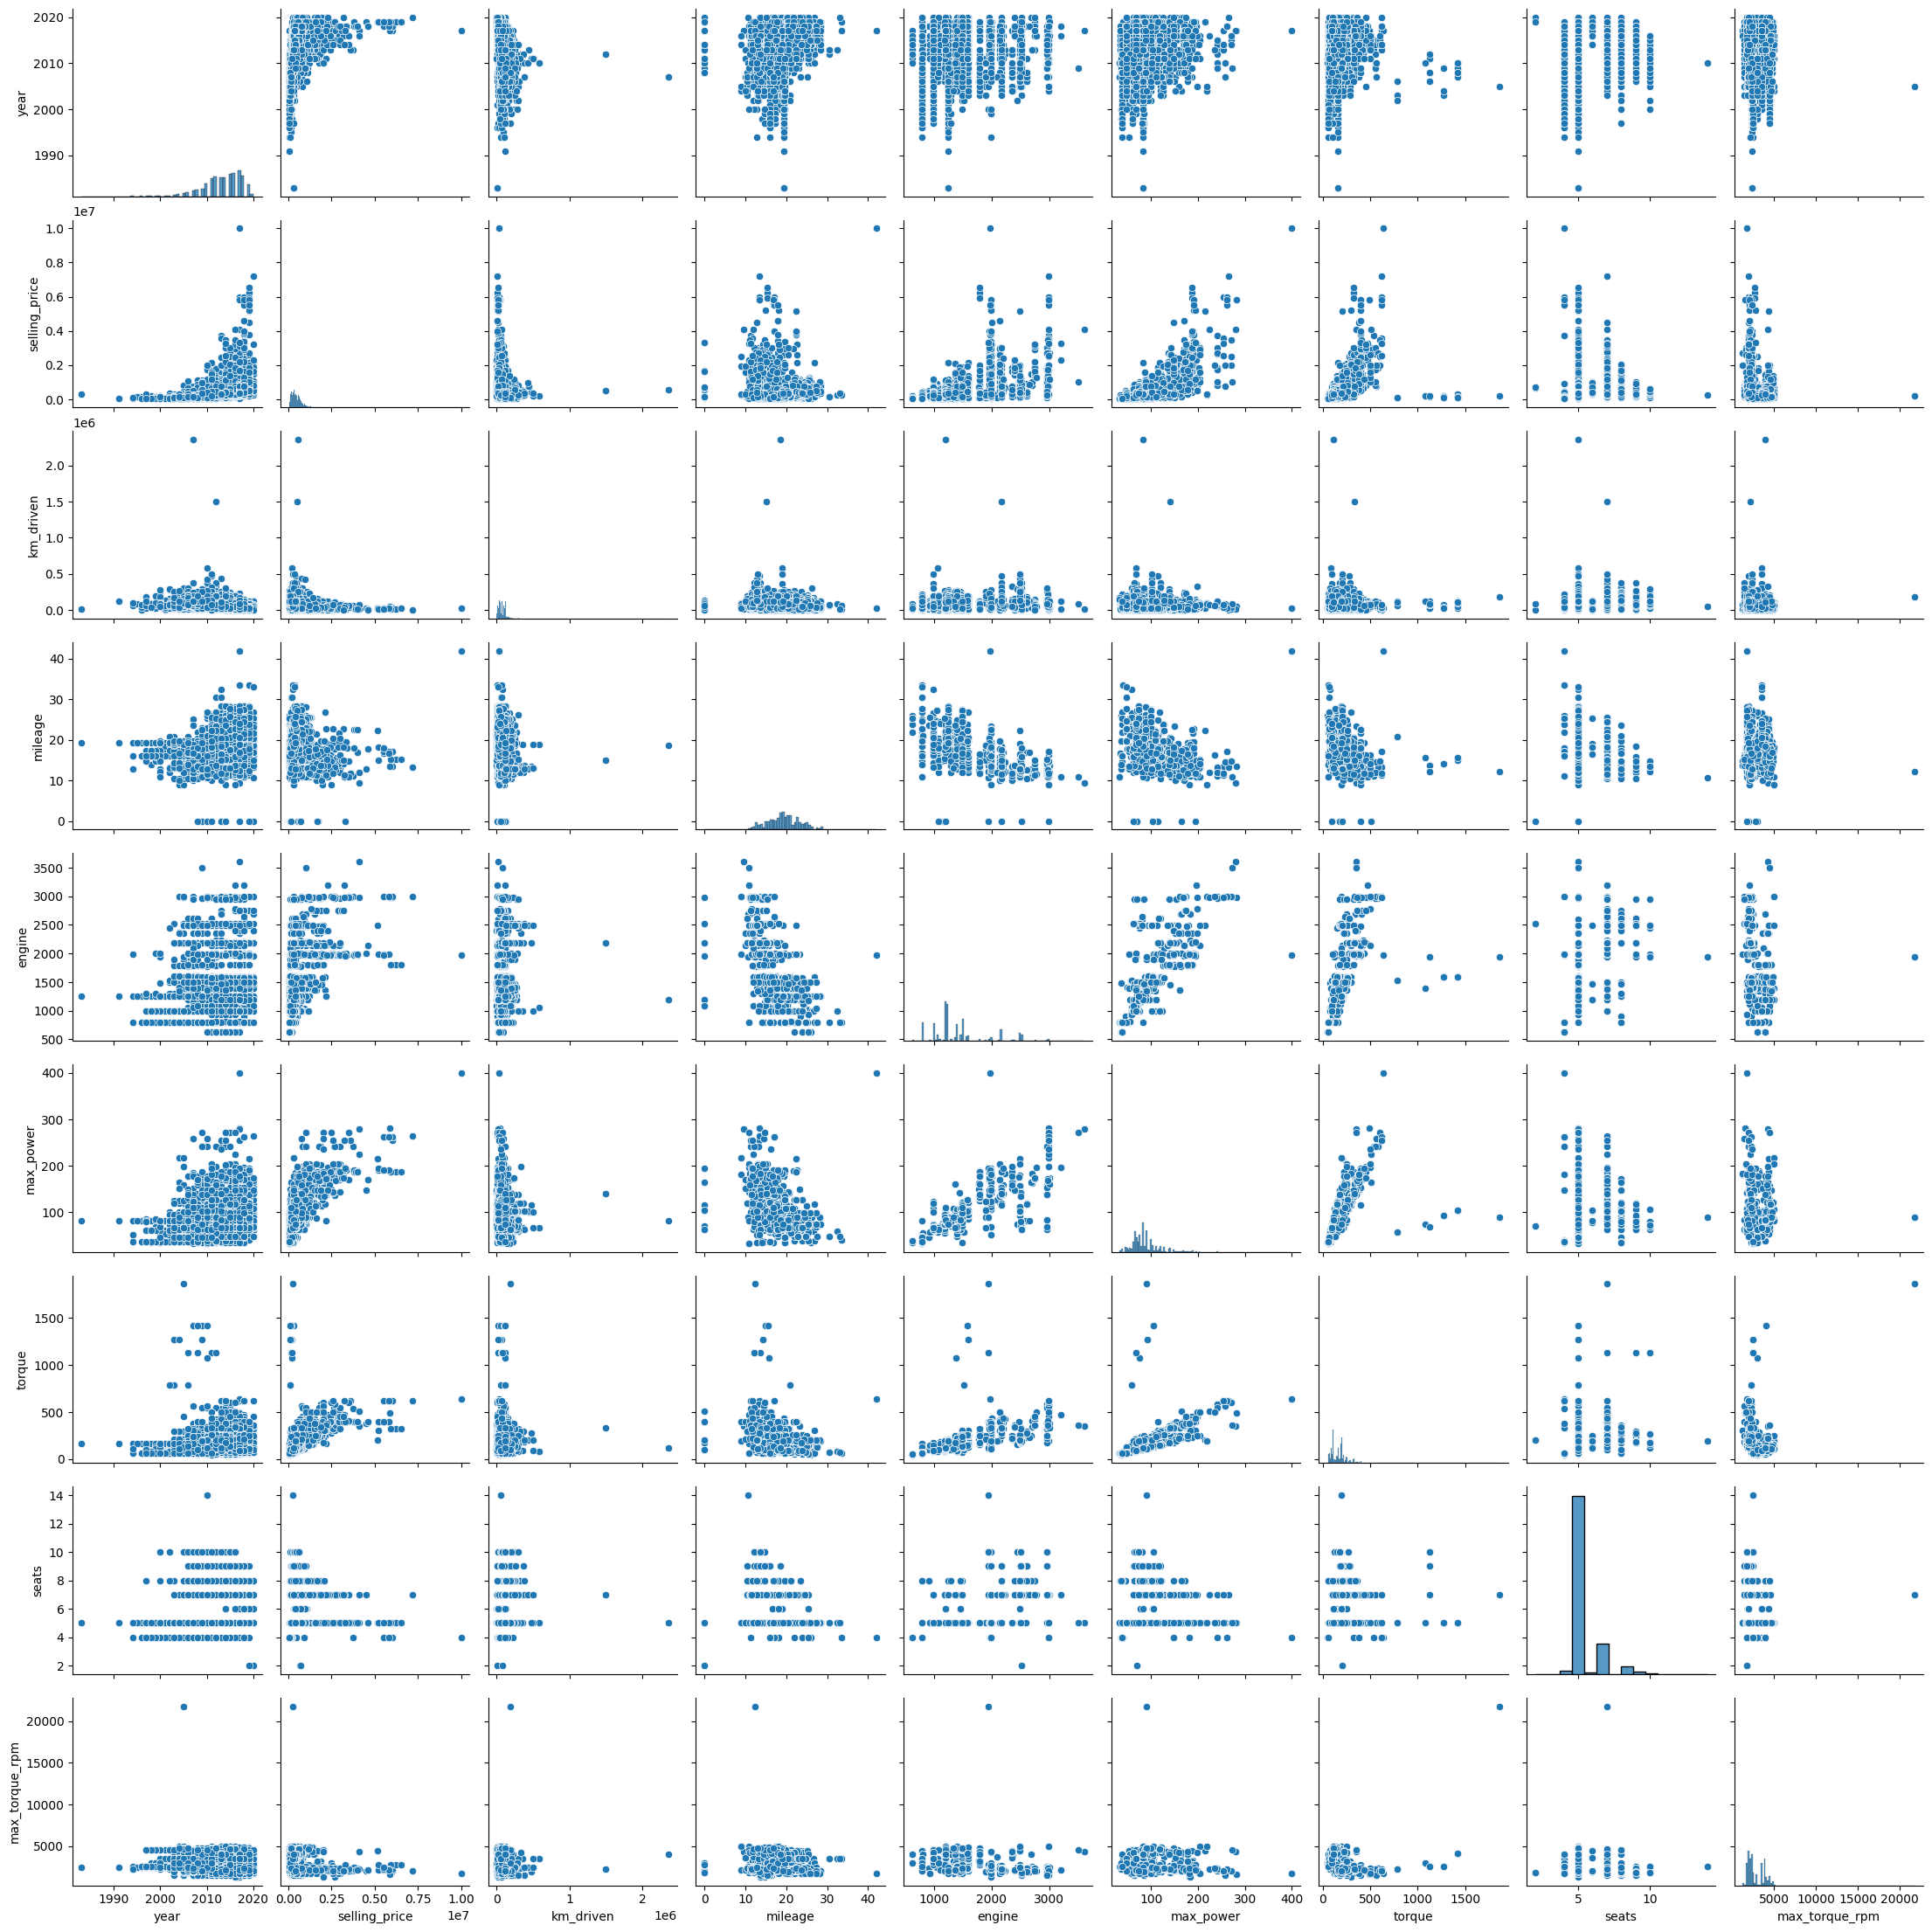

In [37]:
# Построим попарные графики для числовых признаков
# Обучающая выборка
sns.pairplot(df_train)
plt.show()

На основе распределений можно предположить связь с целевой переменной и корреляцию с признаками (как уже отмечалось ранее при анализе отчёта на этапе EDA): года выпуска, максимальная мощность, максимальный крутящий момент, объём двигателя.

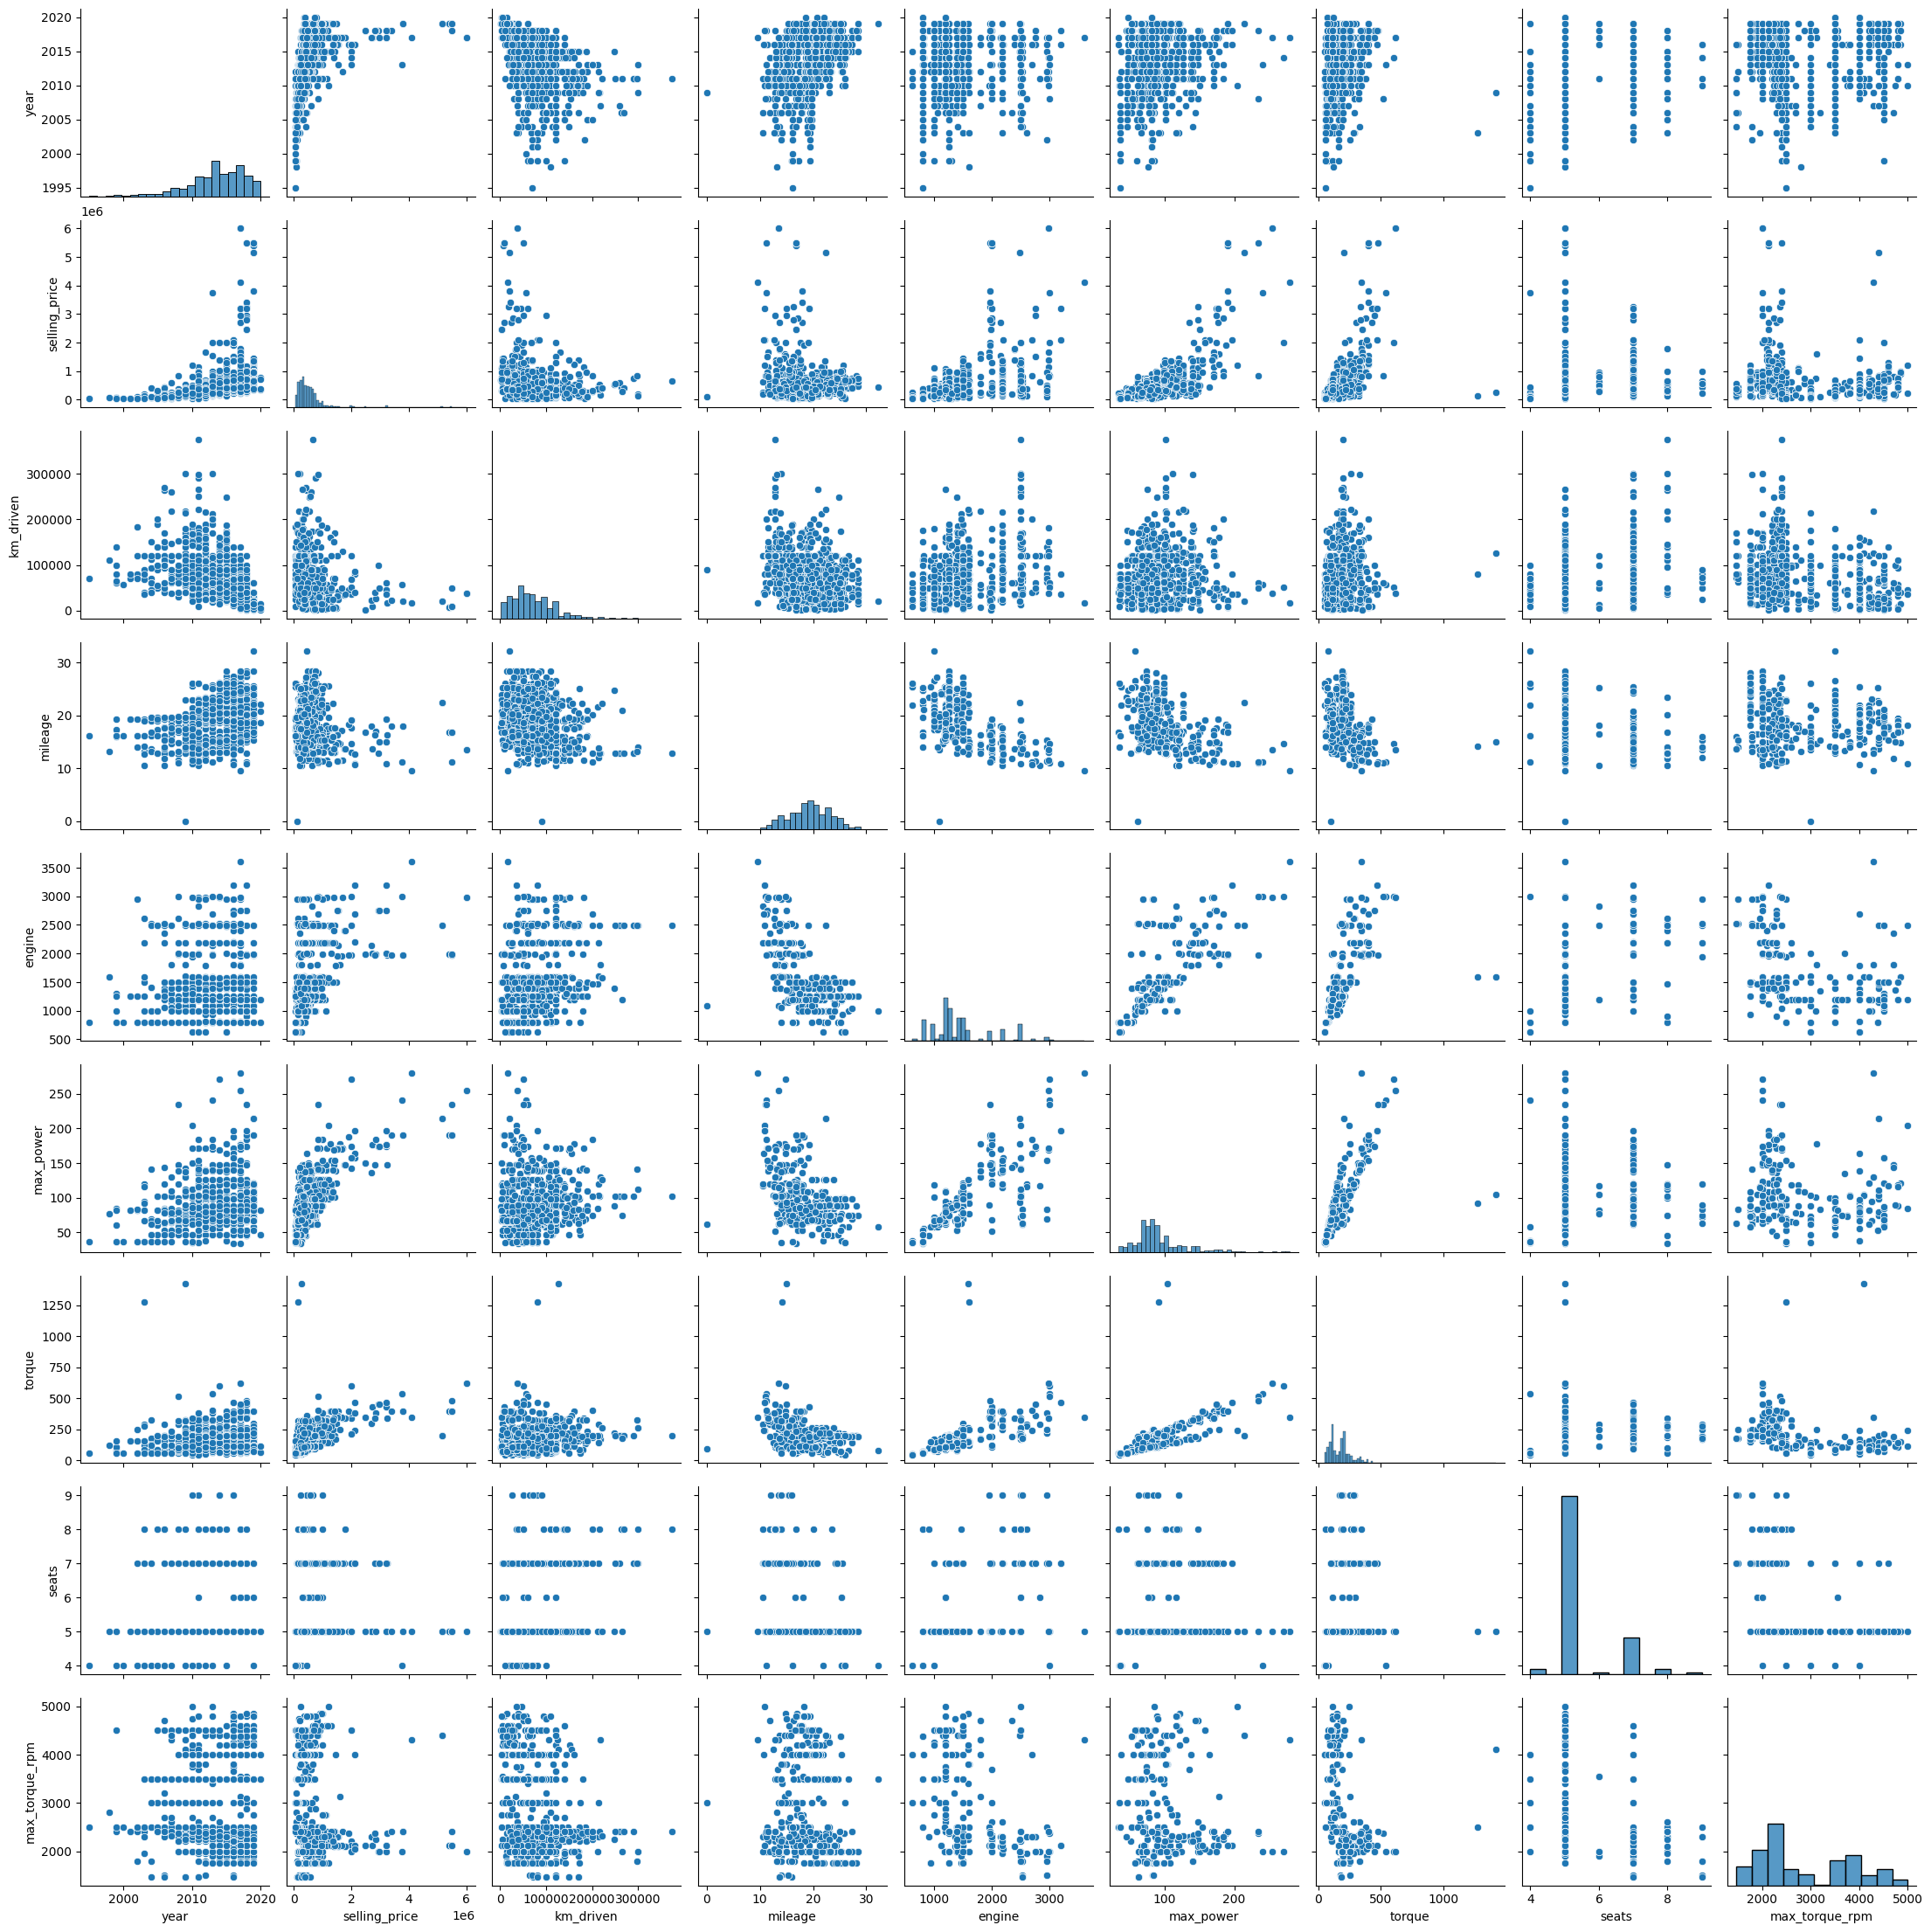

In [38]:
# Тестовая выборка
sns.pairplot(df_test)
plt.show()

Как уже отмечалось ранее на этапе анализа отчёта EDA, совокупности при разделении на трейн и тест похожи.

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [x] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [x] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

In [39]:
# Получим значения коэффициента корреляции Пирсона
corr = df_train.corr(numeric_only=True) # матрица корреляций
corr

year  selling_price  km_driven   mileage    engine  \
year            1.000000       0.427279  -0.368966  0.341334  0.002819   
selling_price   0.427279       1.000000  -0.164828 -0.104769  0.447672   
km_driven      -0.368966      -0.164828   1.000000 -0.182086  0.229766   
mileage         0.341334      -0.104769  -0.182086  1.000000 -0.572893   
engine          0.002819       0.447672   0.229766 -0.572893  1.000000   
max_power       0.157138       0.693742   0.024539 -0.374150  0.681968   
torque          0.053151       0.466466   0.112956 -0.237616  0.600069   
seats           0.041178       0.149953   0.192328 -0.451059  0.652172   
max_torque_rpm  0.032678      -0.177878  -0.232456 -0.090629 -0.385459   

                max_power    torque     seats  max_torque_rpm  
year             0.157138  0.053151  0.041178        0.032678  
selling_price    0.693742  0.466466  0.149953       -0.177878  
km_driven        0.024539  0.112956  0.192328       -0.232456  
mileage         -0.374150 -0.237616 -0.451059       -0.090629  
engine           0.681968  0.600069  0.652172       -0.385459  
max_power        1.000000  0.661083  0.244017       -0.157038  
torque           0.661083  1.000000  0.316274       -0.369355  
seats            0.244017  0.316274  1.000000       -0.297322  
max_torque_rpm  -0.157038 -0.369355 -0.297322        1.000000

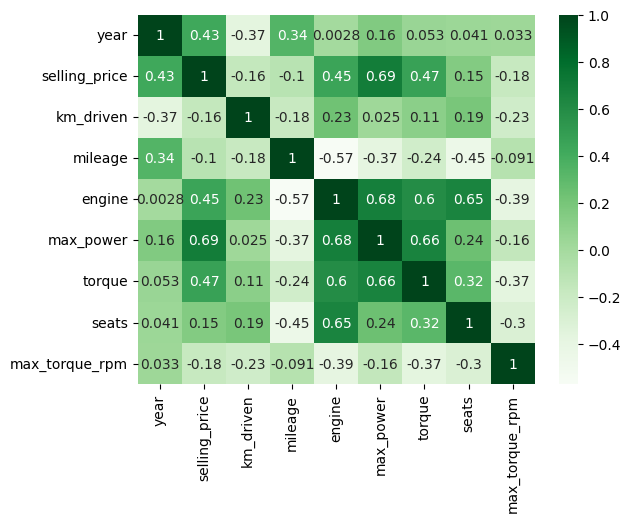

In [40]:
# По полученным корреляциям построим тепловую карту
sns.heatmap(corr, cmap="Greens", annot=True)
plt.show()

Гипотезы по корреляции с целевым признаком подтверждаются.

- [x] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?

Можно заметить:
- наименьшая корреляция наблюдается между годом выпуска и объёмом двигателя;
- сильная линейная зависимость имеется между ценой и максимальной мощностью, объёмом двигателя и количеством мест, максимальным крутящим моментом, максимальной мощностью, максимальным крутящим моментом и максимальной мощностью;
- между годом выпуска и пробегом наблюдается отрицательная корреляция, поэтому можно утверждать, что чем меньше год, тем, скорее всего, пробег будет больше.

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [x] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [x]

Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [x] Проинтерпретируйте результаты


#### Корреляция Спирмена

In [41]:
# Определим функцию для вычисления корреляции Спирмена
def my_spearman(df):
    result = pd.DataFrame(data=np.zeros((len(df.columns), len(df.columns))),
                          index=df.columns,
                          columns=df.columns)
    df = df.copy()
    n = df.shape[0]
    columns = df.columns
    for col_1 in df.columns:
        for col_2 in columns:
            # Определим ранги значений, не обращая внимание на одинаковые значения
            # Для одной колонки
            r_1 = df[col_1].rank().values
            # Для другой колонки
            r_2 = df[col_2].rank().values

            # Вычислим коэффициент корреляции Пирсона для рангов
            result.loc[col_1, col_2] = \
             ((r_1 - r_1.mean()) * (r_2 - r_2.mean())).sum() / \
             (((((r_1 - r_1.mean())**2).sum())**0.5) * ((((r_2 - r_2.mean())**2).sum())**0.5))

    return result

In [42]:
# Составим список категориальных признаков
cat_features = df_train.select_dtypes(include='object').columns.to_list()
cat_features

['name', 'fuel', 'seller_type', 'transmission', 'owner']

In [43]:
# Составим список числовых признаков
num_features = (
    df_train
    .select_dtypes(include=['int', 'float'])
    .columns.to_list()
)
num_features

['year',
 'selling_price',
 'km_driven',
 'mileage',
 'engine',
 'max_power',
 'torque',
 'seats',
 'max_torque_rpm']

In [44]:
# Вычисли корреляцию Спирмена совей функцией
my_spearman(df_train[num_features])

year  selling_price  km_driven   mileage    engine  \
year            1.000000       0.707123  -0.569659  0.346132 -0.038056   
selling_price   0.707123       1.000000  -0.295665  0.026186  0.463577   
km_driven      -0.569659      -0.295665   1.000000 -0.198466  0.304504   
mileage         0.346132       0.026186  -0.198466  1.000000 -0.429871   
engine         -0.038056       0.463577   0.304504 -0.429871  1.000000   
max_power       0.165793       0.612321   0.040975 -0.309037  0.713510   
torque          0.102610       0.582409   0.242914 -0.162372  0.842425   
seats           0.048291       0.317605   0.195317 -0.435458  0.527716   
max_torque_rpm  0.002972      -0.257520  -0.310927 -0.153287 -0.473456   

                max_power    torque     seats  max_torque_rpm  
year             0.165793  0.102610  0.048291        0.002972  
selling_price    0.612321  0.582409  0.317605       -0.257520  
km_driven        0.040975  0.242914  0.195317       -0.310927  
mileage         -0.309037 -0.162372 -0.435458       -0.153287  
engine           0.713510  0.842425  0.527716       -0.473456  
max_power        1.000000  0.780125  0.304688       -0.153751  
torque           0.780125  1.000000  0.438209       -0.653567  
seats            0.304688  0.438209  1.000000       -0.314851  
max_torque_rpm  -0.153751 -0.653567 -0.314851        1.000000

In [45]:
# Сравним с результатом библиотечной функции
corr = df_train.corr(method='spearman', numeric_only=True)
print(f'Сумма квадратов ошибки {((corr.values - my_spearman(df_train[num_features]).values)**2).sum()}')
corr

Сумма квадратов ошибки 1.818318608744599e-31


year  selling_price  km_driven   mileage    engine  \
year            1.000000       0.707123  -0.569659  0.346132 -0.038056   
selling_price   0.707123       1.000000  -0.295665  0.026186  0.463577   
km_driven      -0.569659      -0.295665   1.000000 -0.198466  0.304504   
mileage         0.346132       0.026186  -0.198466  1.000000 -0.429871   
engine         -0.038056       0.463577   0.304504 -0.429871  1.000000   
max_power       0.165793       0.612321   0.040975 -0.309037  0.713510   
torque          0.102610       0.582409   0.242914 -0.162372  0.842425   
seats           0.048291       0.317605   0.195317 -0.435458  0.527716   
max_torque_rpm  0.002972      -0.257520  -0.310927 -0.153287 -0.473456   

                max_power    torque     seats  max_torque_rpm  
year             0.165793  0.102610  0.048291        0.002972  
selling_price    0.612321  0.582409  0.317605       -0.257520  
km_driven        0.040975  0.242914  0.195317       -0.310927  
mileage         -0.309037 -0.162372 -0.435458       -0.153287  
engine           0.713510  0.842425  0.527716       -0.473456  
max_power        1.000000  0.780125  0.304688       -0.153751  
torque           0.780125  1.000000  0.438209       -0.653567  
seats            0.304688  0.438209  1.000000       -0.314851  
max_torque_rpm  -0.153751 -0.653567 -0.314851        1.000000

Как видим, библиотечная и собственная реализации дали практически одинаковые результаты.

#### Корреляция phik

In [46]:
# Воспользуемся библиотекой Phik для построения матрицы корреляции признаков
cor_matrix = df_train.phik_matrix(
    interval_cols=num_features
)

/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable name is large: 1924. Are you sure this is not an interval variable? Analysis for pairs of variables including name can be slow.
  warnings.warn(


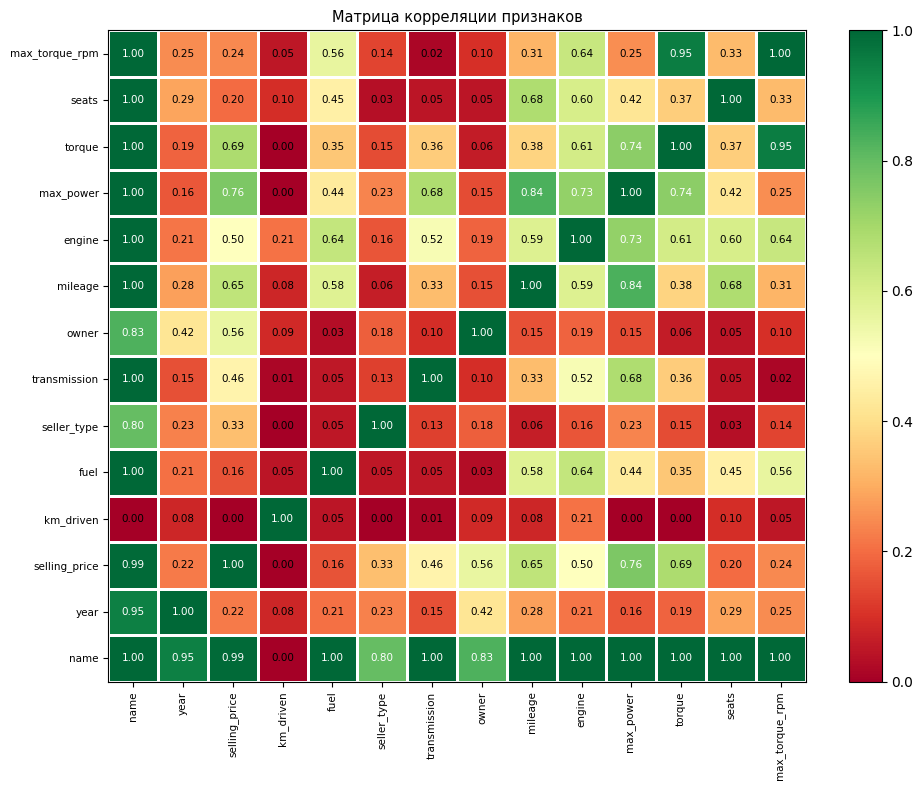

In [47]:
zvalues = cor_matrix.values
xlabels = cor_matrix.columns
ylabels = cor_matrix.index
plot_correlation_matrix(zvalues,
                        x_labels=xlabels,
                        y_labels=ylabels,
                        vmin=0, vmax=1, title='Матрица корреляции признаков',
                        figsize=(10, 8),
                        identity_layout=False, fontsize_factor=0.75)

В целом все ранее сделанные выводы справедливы.  
В частности, по целевой переменной можно видеть корреляцию с признаками: максимальная мощность, максимальный крутящий момент, объём двигателя. При  также можно увидеть корреляцию с запасом хода на 1 л, порядковым номером владельца, типом коробки передач.  
Обращает на себя внимание и большая корреляция максимального крутящего момента с оборотами, на которых этот момент достигается.

### **Дополнительные визуализации (бонус 0.2 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.

In [48]:
# Определим функцию, которая строит график зависимости целевого
# признака от значений исследуемого
def show_target_dependence(dataset: pd.DataFrame,
                           factor: str,
                           target: str,
                           is_cat = True) -> None:
    '''Принимает датасет, название исследуемого и целевого признака, флаг
    категориальности исследуемого признака, строит график зависимости целевого
    признака от значений исследуемого'''
    df = dataset[[factor, target]].copy()
    average = df[target].mean()
    fig = plt.figure(figsize=(11, 5))
    plt.title(f'Связь значений признака {factor} с целевым признаком {target}')
    plt.xlabel(f'Значения признака {factor}')
    plt.ylabel(f'Среднее значение {target}')
    if is_cat:
        df[factor] = df[factor].apply(str)
        data = df.groupby(by=factor)[target].agg(['mean'])
        labels = data.index
        plt.bar(labels, data['mean'])
    else:
        # Определим значения признака, для которых будем считать среднее
        x_step = (df[factor].max() - df[factor].min())/40
        for step in [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2,
                     0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000,
                     2000, 5000, 1e4, 2e4, 5e4, 1e5]:
            if x_step / step < 1.5:
                x_step = step
                break
        # Сгруппируем данные по значениям исследуемого признака
        df[factor + '_rounded'] = round(df[factor] / x_step) * x_step
        data = df.groupby(by=factor + '_rounded')[target].agg(['mean'])
        labels = data.index
        plt.scatter(labels, data['mean'])
    plt.plot(
        [labels[0],labels[-1]],
        [average]*2,
        color='red',
        label='В среднем по выборке',
        linestyle = '--')
    plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
    plt.legend()
    plt.show()
    plt.close('all')

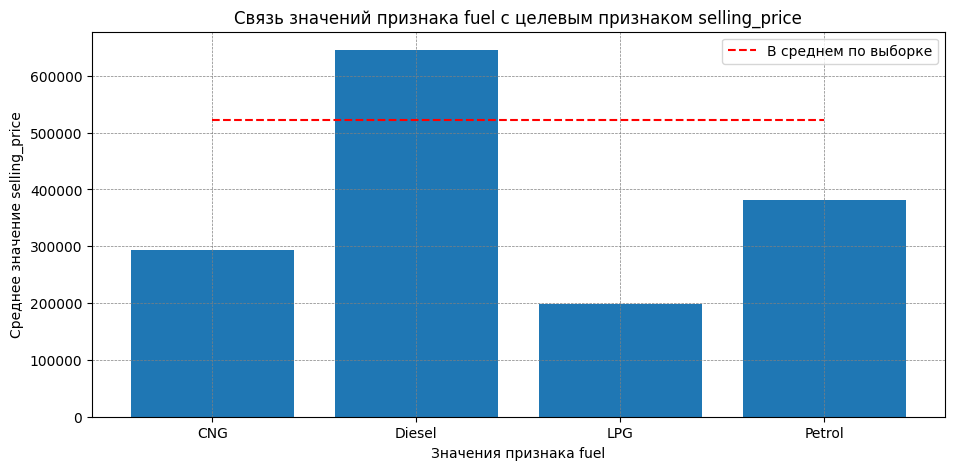

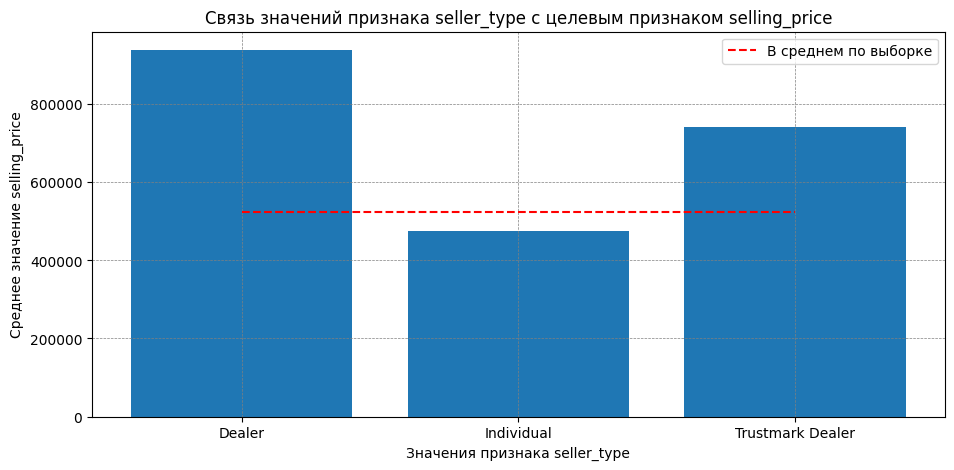

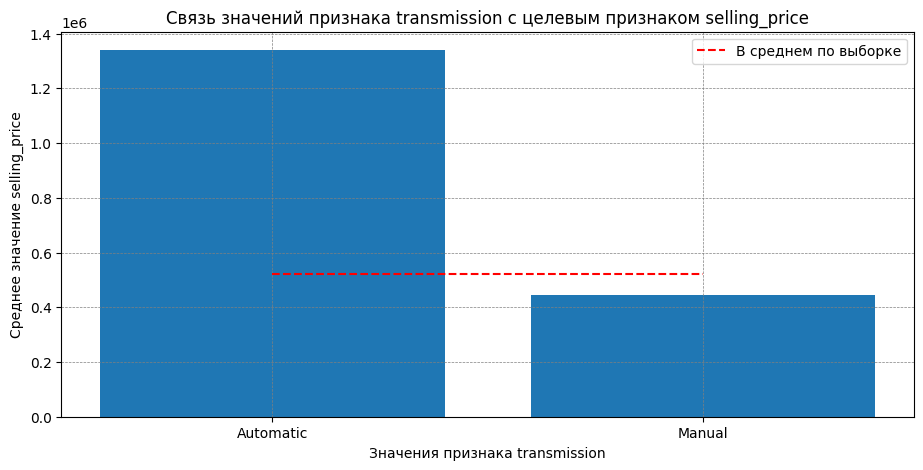

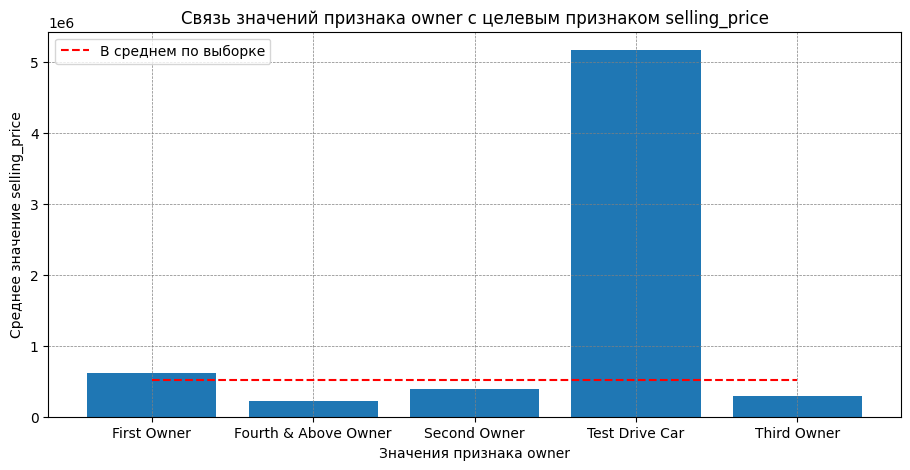

In [49]:
# Посмотрим на связь с целевым признаком категориальных признаков
# кроме наименования (слишком много уникальных значений)
for factor in cat_features[1:]:
    show_target_dependence(dataset=df_train,
                           factor=factor,
                           target='selling_price',
                           is_cat = True)

Можно сделать дополнительные выводы:
- самые дорогие автомобили на дизельном топливе, а самые дешёвые на сжиженном газе;
- цены у дилеров ниже, чем у индивидуальных продавцов;
- автомобили с автоматической коробкой существенно дороже, чем с ручной коробкой,
- цена автомобиля от первого владельца выше, чем от второго и последующих. Цена одного объекта (авто с тестдрайва) не показательна для сравнения категорий.

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [50]:
# Список признаков
X = ['name', 'year', 'km_driven', 'fuel', 'seller_type', 'transmission',
     'owner', 'mileage', 'engine', 'max_power', 'torque', 'seats',
     'max_torque_rpm']

# Целевая переменная
y = 'selling_price'

In [51]:
# Создадим список числовых переменных
num_features = (
    df_train[X]
    .select_dtypes(include=['int', 'float'])
    .columns.to_list()
)
num_features

['year',
 'km_driven',
 'mileage',
 'engine',
 'max_power',
 'torque',
 'seats',
 'max_torque_rpm']

In [52]:
y_train = df_train[y].copy()
X_train_num = df_train[num_features].copy()

In [53]:
# Проверим размерность
X_train_num.shape, y_train.shape

((5840, 8), (5840,))

In [54]:
#assert X_train.shape == (5840, 6)

In [55]:
y_test = df_test[y].copy()
X_test_num = df_test[num_features].copy()

In [56]:
# Проверим размерность
X_test_num.shape, y_test.shape

((1000, 8), (1000,))

In [57]:
# assert X_test.shape == (1000, 6)

Меньше 8 признаков числовых не должно было получиться. Не совпало с ассертом. Возможно, ассерт не совсем корректный.

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [x] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [x] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [58]:
# Создадим модель
lr_num = LinearRegression()

# Обучим модель
lr_num.fit(X_train_num, y_train)

# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, lr_num.predict(X_train_num))}')
print(f'MSE {MSE(y_train, lr_num.predict(X_train_num))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, lr_num.predict(X_test_num))}')
print(f'MSE {MSE(y_test, lr_num.predict(X_test_num))}')

# Сохраним модель
try:
    _ = joblib.dump(lr_num,
                    os.path.join(MODEL_PATH, 'lr_num.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(lr_num,
                    'lr_num.pkl',
                    compress=0)

Обучающая выборка
R2 0.6023226409398248
MSE 113989577403.56126
Тестовая выборка
R2 0.5998006183623494
MSE 230046032514.16925
Changed directory for model to current directory


Качество модели невысокое: только 60% дисперсии "объясняется" моделью. Хорошим показателем можно считать хотя бы 80%.

### **Задание 13 (0.15 балла)**

- [x] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

In [59]:
# Определим функцию
def my_r2(y_true, y_pred):
    y_true = y_true.values
    return 1 - ((y_true - y_pred)**2).sum() / ((y_true - y_true.mean())**2).sum()

In [60]:
# Вычислим метрики собственной функцией для проверки
print('Обучающая выборка')
print(f'R2 {my_r2(y_train, lr_num.predict(X_train_num))}')
print('Тестовая выборка')
print(f'R2 {my_r2(y_test, lr_num.predict(X_test_num))}')

Обучающая выборка
R2 0.6023226409398248
Тестовая выборка
R2 0.5998006183623494


Полученные значения не отличаются от результатов работы библиотечной функции.

В числителе дроби вычисляется сумма квадратов ошибок модели, в знаменателе - дисперсия целевой переменной. Чем меньше сумма квадратов ошибок модели по отношению к дисперсии целевой переменной, тем большая доля отклонений от среднего значения "объясняется" моделью, тем качественнее модель.

### **Бонус (0.15 балла)**

- [x] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [x] Объясните, когда применяется $\text{adjusted}-R^2$?

In [61]:
# Реализуем adjusted R2
def my_r2_adjusted(y_true, y_pred, p):
    '''
    y_true - значения целевой переменной
    y_pred - предсказания модели
    p - количество признаков
    '''
    n = y_true.shape[0]
    y_true = y_true.values

    model_sq_error_sum = ((y_true - y_pred)**2).sum()
    data_variance_sum = ((y_true - y_true.mean())**2).sum()
    # не забудем про свободный вес в модели, к p прибавим 1
    return 1 - (model_sq_error_sum / data_variance_sum) * ((n - 1) / (n - (p + 1) - 1))

In [62]:
# Вычислим метрики собственной функцией для проверки
print('Обучающая выборка')
print(f'R2_adjusted {my_r2_adjusted(y_train, lr_num.predict(X_train_num), X_train_num.shape[1])}')
print('Тестовая выборка')
print(f'R2_adjusted {my_r2_adjusted(y_test, lr_num.predict(X_test_num), X_test_num.shape[1])}')

Обучающая выборка
R2_adjusted 0.6017087307800406
Тестовая выборка
R2_adjusted 0.5961624421656435


R2 не уменьшается при увеличении количества признаков, скорее увеличивается, поскольку ошибка модели всегда минимизируется при обучении. Если требуется сравнивать модели с разным числом факторов, то в качестве альтернативной метрики применяют R2 adjusted, чтоб число факторов не влияло на метрику. Дополнительно включённые факторы при такой метрике негативно влияют на метрику, тем самым нивелируя увеличение их количества.

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [x] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [63]:
# Создадим и обучим скалер
scaler = StandardScaler()
scaler.fit(X_train_num)

# Масштабируем обучающую выборку
X_train_num_scaled = X_train_num.copy()
X_train_num_scaled = scaler.transform(X_train_num_scaled)

# C подготовленным на обучающей выборке скалером выполним масштабирование признаков тестовой выборки
X_test_num_scaled = X_test_num.copy()
X_test_num_scaled = scaler.transform(X_test_num_scaled)

In [64]:
# Обучим модель
lr_num_scaled = LinearRegression()
lr_num_scaled.fit(X_train_num_scaled, y_train)

# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, lr_num_scaled.predict(X_train_num_scaled))}')
print(f'MSE {MSE(y_train, lr_num_scaled.predict(X_train_num_scaled))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, lr_num_scaled.predict(X_test_num_scaled))}')
print(f'MSE {MSE(y_test, lr_num_scaled.predict(X_test_num_scaled))}')

# Сохраним модель
try:
    _ = joblib.dump(lr_num_scaled,
                    os.path.join(MODEL_PATH, 'lr_num_scaled.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(lr_num_scaled,
                    'lr_num_scaled.pkl',
                    compress=0)

Обучающая выборка
R2 0.602322640939825
MSE 113989577403.56117
Тестовая выборка
R2 0.5998006183623514
MSE 230046032514.1681
Changed directory for model to current directory


### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [x] Какой признак оказался наиболее информативным в предсказании цены?

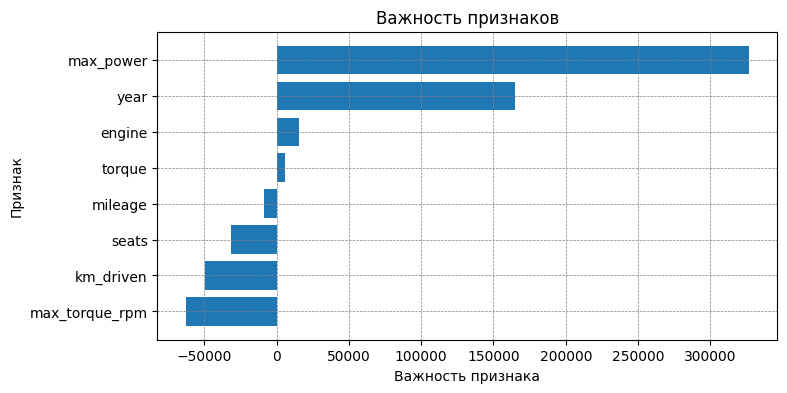

In [65]:
# Проверим важность признаков с точки зрения модели
importances = lr_num_scaled.coef_
importances = pd.Series(
    importances,
    index = X_train_num.columns
).sort_values()
# Построим диаграмму для наглядности
plt.figure(figsize=(8, 4))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

Признак максимальная мощность оказался самым информативным с точки зрения модели.

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [x] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [x] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [66]:
# Создадим модель
lr_lasso = Lasso()

# Обучим модель
lr_lasso.fit(X_train_num_scaled, y_train)

# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, lr_lasso.predict(X_train_num_scaled))}')
print(f'MSE {MSE(y_train, lr_lasso.predict(X_train_num_scaled))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, lr_lasso.predict(X_test_num_scaled))}')
print(f'MSE {MSE(y_test, lr_lasso.predict(X_test_num_scaled))}')

Обучающая выборка
R2 0.602322640894716
MSE 113989577416.49117
Тестовая выборка
R2 0.5997993653903742
MSE 230046752758.24005


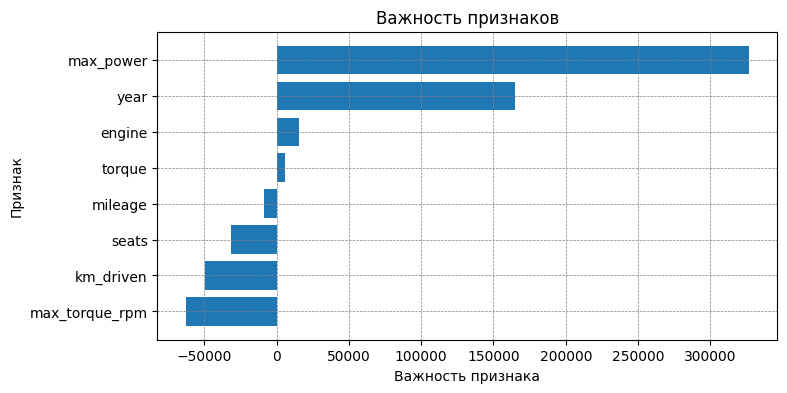

In [67]:
# Проверим важность признаков с точки зрения модели
importances = lr_lasso.coef_
importances = pd.Series(
    importances,
    index = X_train_num.columns
).sort_values()
# Построим диаграмму для наглядности
plt.figure(figsize=(8, 4))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

Никакие веса не были занулены. Значение alpha по умолчанию таково, что до зануления какого-то из весов алгоритм не дошёл в ходе обучения.

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [x] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [x] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей? **Ответ 1000**
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый **Один параметр 'lasso__alpha' - это параметр alpha шага пайплайна Lasso (сама линейная модель). Это коэффициент регуляризации, который определяет силу регуляризации**
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации? **Получилось значение ~22000-23000. Да, занулилось несколько весов.**

In [68]:
# Определим набор преобразований столбцов
col_transformer = make_column_transformer(
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=True
)

In [69]:
# Пайплайн обработки данных и обучения модели Lasso
lasso_pl = make_pipeline(col_transformer, Lasso())


param_grid_lasso = {
    'lasso__alpha': np.linspace(1, 50000, 100)
}
gs_lasso_pl = GridSearchCV(
                           lasso_pl,
                           param_grid=param_grid_lasso,
                           scoring='r2',
                           cv=10,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_lasso_pl.fit(X_train_num, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_lasso_pl.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_lasso_pl.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_lasso_pl.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_lasso_pl.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_lasso_pl.best_estimator_,
                    'gs_lasso_pl.pkl',
                    compress=0)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
best_score: 0.5835490851712248
best_params: {'lasso__alpha': 22727.81818181818}
Changed directory for model to current directory


In [70]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, gs_lasso_pl.best_estimator_.predict(X_train_num))}')
print(f'MSE {MSE(y_train, gs_lasso_pl.best_estimator_.predict(X_train_num))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_lasso_pl.best_estimator_.predict(X_test_num))}')
print(f'MSE {MSE(y_test, gs_lasso_pl.best_estimator_.predict(X_test_num))}')

Обучающая выборка
R2 0.5943283389167601
MSE 116281050851.7836
Тестовая выборка
R2 0.5724880402953607
MSE 245746082315.17862


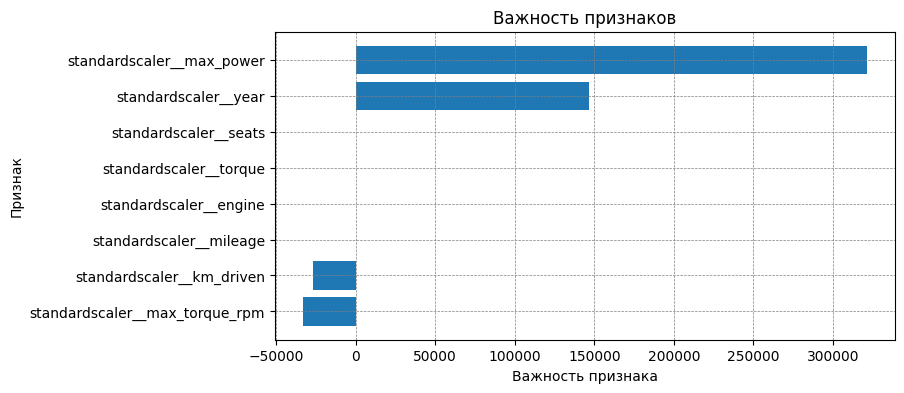

In [71]:
# Проверим важность признаков с точки зрения модели
importances = gs_lasso_pl.best_estimator_['lasso'].coef_
importances = pd.Series(
    importances,
    index=gs_lasso_pl.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
# Построим диаграмму для наглядности
plt.figure(figsize=(8, 4))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
#plt.xlim([0, 20])
#plt.xticks(np.arange(0, 20, step=1), rotation=0)
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

**Ваша задача 2:**

- [x] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [x] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей? **20000**
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей? **alpha: ~22000-23000, l1_ratio: 1.0**. По сути gridsearch пришёл к той же модели Лассо (L1 регуляризация).

In [72]:
# Пайплайн обработки данных и обучения модели ElasticNet
elnet_pl = make_pipeline(col_transformer, ElasticNet())

param_grid_elnet = {
    'elasticnet__alpha': np.linspace(1, 50000, 100),
    'elasticnet__l1_ratio': np.linspace(0.01, 1, 20),
}
gs_elnet_pl = GridSearchCV(
                           elnet_pl,
                           param_grid=param_grid_elnet,
                           scoring='r2',
                           cv=10,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_elnet_pl.fit(X_train_num, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_elnet_pl.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_elnet_pl.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_elnet_pl.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_elnet_pl.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_elnet_pl.best_estimator_,
                    'gs_elnet_pl.pkl',
                    compress=0)

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits
best_score: 0.5835490851712248
best_params: {'elasticnet__alpha': 22727.81818181818, 'elasticnet__l1_ratio': 1.0}
Changed directory for model to current directory


In [73]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, gs_elnet_pl.best_estimator_.predict(X_train_num))}')
print(f'MSE {MSE(y_train, gs_elnet_pl.best_estimator_.predict(X_train_num))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_elnet_pl.best_estimator_.predict(X_test_num))}')
print(f'MSE {MSE(y_test, gs_elnet_pl.best_estimator_.predict(X_test_num))}')

Обучающая выборка
R2 0.5943283389167601
MSE 116281050851.7836
Тестовая выборка
R2 0.5724880402953607
MSE 245746082315.17862


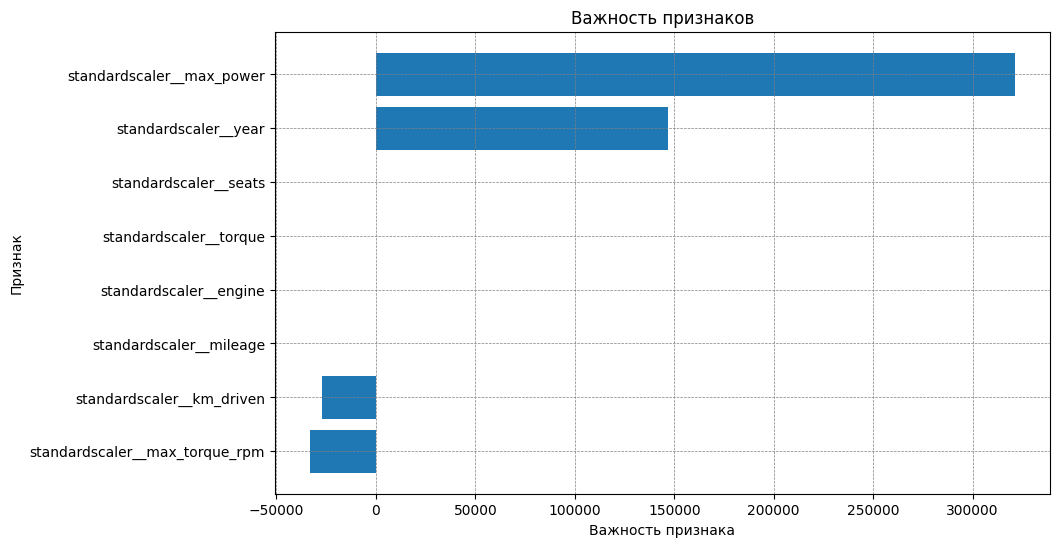

In [74]:
# Проверим важность признаков с точки зрения модели
importances = gs_elnet_pl.best_estimator_['elasticnet'].coef_
importances = pd.Series(
    importances,
    index=gs_elnet_pl.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
# Построим диаграмму для наглядности
plt.figure(figsize=(10, 6))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [x] Реализуйте модель с $L0$-регуляризаицей.
- [x] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [x] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



Реализуем L0 регуляризацию с использованием **AIC** (информационный критерий Акаике) и **BIC** (байесовский информационный критерий).

In [75]:
# Функция для расчета AIC и BIC для многомерной регрессии
def calculate_aic_bic_multi(model, X, Y):
    n, k = X.shape[0], X.shape[1]  # Число наблюдений и признаков
    n_targets = Y.reshape(n, -1).shape[1]  # Число целевых переменных
    y_pred = model.predict(X)
    residual_sum_of_squares = np.sum((Y - y_pred) ** 2)

    # Средняя ошибка для всех компонент целевой переменной
    mse = MSE(Y, y_pred, multioutput='uniform_average')
    log_likelihood = -n * n_targets / 2 * (np.log(2 * np.pi * mse) + 1)

    # Количество параметров = (число признаков + 1) * число целевых переменных
    total_params = n_targets * (k + 1)

    aic = 2 * total_params - 2 * log_likelihood
    bic = total_params * log(n) - 2 * log_likelihood

    return aic, bic

In [76]:
# Перебор комбинаций признаков для минимизации AIC/BIC
min_aic, min_bic = float('inf'), float('inf')
best_aic_model, best_bic_model = None, None

for num_of_features in range(1, X_train_num.shape[1] + 1):
    for feature_subset in combinations(X_train_num.columns, num_of_features):
        # Подготовка данных
        X_subset = X_train_num[list(feature_subset)].values
        Y_subset = y_train.values #df_train[[f"Target_{i}" for i in range(n_targets)]].values

        # Обучение модели
        model = LinearRegression()
        model.fit(X_subset, Y_subset)

        # Расчет AIC и BIC
        aic, bic = calculate_aic_bic_multi(model, X_subset, Y_subset)

        # Обновление лучших моделей
        if aic < min_aic:
            min_aic = aic
            best_aic_model = (model, feature_subset)

        if bic < min_bic:
            min_bic = bic
            best_bic_model = (model, feature_subset)

# 4. Вывод результатов
print(f"Best AIC: {min_aic:.2f} using features {best_aic_model[1]}")
print(f"Best BIC: {min_bic:.2f} using features {best_bic_model[1]}")

Best AIC: 165272.21 using features ('year', 'km_driven', 'engine', 'max_power', 'seats', 'max_torque_rpm')
Best BIC: 165315.63 using features ('year', 'km_driven', 'max_power', 'seats', 'max_torque_rpm')


В результате обучения получилось, что признаки 'year', 'km_driven', 'max_power', которые оставались незанулёнными в ходе подбора гиперпараметров на предыдущих шагах, присутствуют и в обеих моделях с L0 регуляризацией.

# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [x] Предобработайте столбец `name`, чтобы избежать его удаления

In [77]:
# Посмотрим, сколько уникальных значений имеется
df_train['name'].nunique()

1924

In [78]:
# Изучим наименования
sorted(df_train['name'].unique())

['Ambassador CLASSIC 1500 DSL AC',
 'Ambassador Classic 2000 DSZ AC PS',
 'Ambassador Grand 2000 DSZ PW CL',
 'Audi A3 35 TDI Premium Plus',
 'Audi A3 40 TFSI Premium',
 'Audi A4 1.8 TFSI',
 'Audi A4 2.0 TDI',
 'Audi A4 2.0 TDI 177 Bhp Premium Plus',
 'Audi A4 35 TDI Premium Plus',
 'Audi A6 2.0 TDI',
 'Audi A6 2.0 TDI  Design Edition',
 'Audi A6 2.0 TDI Technology',
 'Audi A6 35 TFSI Matrix',
 'Audi Q3 2.0 TDI Quattro Premium Plus',
 'Audi Q3 35 TDI Quattro Premium Plus',
 'Audi Q3 35 TDI Quattro Technology',
 'Audi Q5 2.0 TDI',
 'Audi Q5 3.0 TDI Quattro',
 'Audi Q5 35TDI Premium Plus',
 'Audi Q5 45 TDI quattro Technology',
 'Audi Q7 3.0 TDI Quattro',
 'Audi Q7 3.0 TDI Quattro Premium Plus',
 'Audi Q7 35 TDI Quattro Premium',
 'BMW 3 Series 320d',
 'BMW 3 Series 320d Corporate Edition',
 'BMW 3 Series 320d GT Luxury Line',
 'BMW 3 Series 320d Highline',
 'BMW 3 Series 320d Luxury Line',
 'BMW 3 Series 320d Luxury Line Plus',
 'BMW 3 Series 320d Luxury Plus',
 'BMW 3 Series 320d Presti

Видим, что первые два слова обозначают марку и модель авто. Выделим их.

In [79]:
# Уникальные марки
df_train['name'].str.split().apply(lambda x: x[0]).unique()

array(['Maruti', 'Skoda', 'Hyundai', 'Toyota', 'Ford', 'Renault',
       'Mahindra', 'Honda', 'Chevrolet', 'Fiat', 'Datsun', 'Tata', 'Jeep',
       'Mercedes-Benz', 'Mitsubishi', 'Audi', 'Volkswagen', 'BMW',
       'Nissan', 'Lexus', 'Jaguar', 'Land', 'MG', 'Volvo', 'Daewoo',
       'Kia', 'Force', 'Ambassador', 'Isuzu', 'Peugeot'], dtype=object)

In [80]:
# Количество уникальных марок
df_train['name'].str.split().apply(lambda x: x[0]).nunique()

30

In [81]:
# Создадим столбец с маркой автомобиля
df_train['car_make'] = df_train['name'].str.split().apply(lambda x: x[0])
df_test['car_make'] = df_test['name'].str.split().apply(lambda x: x[0])

In [82]:
# Уникальные модели
df_train['name'].str.split().apply(lambda x: x[1]).unique()

array(['Swift', 'Rapid', 'i20', 'Xcent', 'Wagon', '800', 'Etios', 'Figo',
       'Duster', 'Zen', 'KUV', 'Alto', 'Verito', 'WR-V', 'SX4', 'Baleno',
       'Enjoy', 'Omni', 'Vitara', 'Palio', 'Verna', 'GO', 'Safari',
       'Compass', 'City', 'Fortuner', 'Innova', 'B', 'Amaze', 'Pajero',
       'Jazz', 'A6', 'New', 'Manza', 'i10', 'Ameo', 'Ertiga', 'Indica',
       'Vento', 'EcoSport', 'X1', 'Celerio', 'Polo', 'Scorpio',
       'Freestyle', 'Passat', 'XUV500', 'Indigo', 'Corolla', 'Terrano',
       'Creta', 'KWID', 'Santro', 'Q5', 'ES', 'XF', 'Rover', 'S-Class',
       '5', 'X4', 'Superb', 'E-Class', 'Hector', 'XC40', 'Q7', 'Ciaz',
       'XE', 'Nexon', 'Elantra', 'CLA', 'Glanza', '3', 'Camry', 'XC90',
       'Ritz', 'Grand', 'Matiz', 'Zest', 'Getz', 'Tigor', 'Hexa', 'Sunny',
       'Ssangyong', 'Quanto', 'Eeco', 'Accent', 'Ignis', 'Marazzo',
       'Tiago', 'Elite', 'Thar', 'Brio', 'Bolero', 'GL-Class', 'Beat',
       'Willys', 'Micra', 'A-Star', 'Nano', 'GTI', 'V40', 'CR-V',
       'R

In [83]:
# Количество уникальных моделей
df_train['name'].str.split().apply(lambda x: x[1]).nunique()

202

In [84]:
# Создадим столбец с моделью автомобиля
df_train['car_model'] = df_train['name'].str.split().apply(lambda x: x[1])
df_test['car_model'] = df_test['name'].str.split().apply(lambda x: x[1])

In [85]:
# Обновим список признаков (name не включаем)
X = ['year', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats', 'max_torque_rpm', 'car_make', 'car_model']

In [86]:
# Составим список категориальных признаков (name не будем включать в набор)
cat_features = df_train.select_dtypes(include='object').columns.to_list()[1:]
cat_features

['fuel', 'seller_type', 'transmission', 'owner', 'car_make', 'car_model']

In [87]:
# Выделим датасет с признаками
X_train_cat = df_train[X].copy()

In [88]:
# Проверим размерность
X_train_cat.shape, y_train.shape

((5840, 14), (5840,))

In [89]:
#assert X_train_cat.shape == (5840, 11)

Признаков при обработке получилось больше

In [90]:
X_train_cat.describe(include='object')

fuel seller_type transmission        owner car_make car_model
count     5840        5840         5840         5840     5840      5840
unique       4           3            2            5       30       202
top     Diesel  Individual       Manual  First Owner   Maruti     Swift
freq      3177        5223         5336         3603     1804       558

In [91]:
# То же для тестовой выборки
X_test_cat = df_test[X].copy()

In [92]:
# Проверим размерность
X_test_cat.shape, y_test.shape

((1000, 14), (1000,))

### **Задание 20 (0.1 балла)**

- [x] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [93]:
# Определим набор преобразований столбцов
col_transformer = make_column_transformer(
    (
        OneHotEncoder(handle_unknown='ignore',
                      drop='first',
                      dtype='int16',
                      sparse_output=False),
        cat_features
    ),
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=True
)

### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

Необходимо при работе с OHE:
- задать параметры работы с неизвестными категориями,
- решить, что делать с одним из столбцов (если линейная модель без регуляризации, то всегда убрается один столбец, т.к. получается линейно зависимый столбец. Если другие модели, то он избыточный по содержащейся информации, однако в некоторых случаях, если его оставить, результаты могут быть лучше),
- решить, что делать с выходм кодировщика (не всегда принимаются разреженные матрицы дальше по пайплайну),
- удалять столбцы только потому, что они оказались незначимыми, не корректно, потому что столбец OHE сам по себе может быть не так важен, но в комбинации с другим признаком может оказаться важным.

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [x] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [x] Ответье на вопрос: Удалось ли улучшить качество прогнозов? **Да, качество прогнозов существенно выросло**

In [94]:
# Пайплайн обработки данных и обучения линейной модели
ridge_pl = make_pipeline(col_transformer, Ridge())

param_grid_ridge = {
    'ridge__alpha': np.linspace(1, 50000, 100)
}
gs_ridge_pl = GridSearchCV(
                           ridge_pl,
                           param_grid=param_grid_ridge,
                           scoring='r2',
                           cv=10,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_ridge_pl.fit(X_train_cat, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_ridge_pl.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_ridge_pl.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_ridge_pl.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_ridge_pl.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_ridge_pl.best_estimator_,
                    'gs_ridge_pl.pkl',
                    compress=0)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
best_score: 0.779878388104747
best_params: {'ridge__alpha': 1.0}
Changed directory for model to current directory


In [95]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, gs_ridge_pl.best_estimator_.predict(X_train_cat))}')
print(f'MSE {MSE(y_train, gs_ridge_pl.best_estimator_.predict(X_train_cat))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_ridge_pl.best_estimator_.predict(X_test_cat))}')
print(f'MSE {MSE(y_test, gs_ridge_pl.best_estimator_.predict(X_test_cat))}')

Обучающая выборка
R2 0.8810168100109074
MSE 34105143870.99422
Тестовая выборка
R2 0.9117148773502788
MSE 50748809537.10213


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 2-х баллов в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

## Анализ выбросов

In [96]:
# Определим функцию, которая строит диаграмму размаха и гистограмму распределения
# значений определённого признака. Набор значений передаётся в качестве параметра
def show_feature_distribution(col: pd.Series) -> None:
    '''Принимает столбец со значениями, строит диаграмму размаха
    и гистограмму распределения значений'''
    fig, ax = plt.subplots(ncols=1, nrows=2,
                           figsize=(16, 6),
                           sharex=True,
                           gridspec_kw={'height_ratios': (.2, .8)})
    fig.suptitle(f'Диаграмма размаха и гистограмма распределения значений {col.name}', fontsize=14)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].tick_params(axis='y', left=False, labelleft=False)
    ax[1].grid(color='gray', linewidth = 0.5, linestyle = '--')

    if type(col[0]) != pd._libs.tslibs.timestamps.Timestamp:
        # Определим шаг шкалы для оси x
        x_step = (col.max() - col.min()) / 20
        for step in [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2,
                     0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000,
                     2000, 5000, 1e4, 2e4, 5e4, 1e5]:
            if x_step / step < 1.5:
                x_step = step
                break
        x_min = x_step * int(col.min() / x_step)
        x_max = x_step * (1 + int(col.max() / x_step))
        ax[1].set_xticks(np.arange(x_min, x_max, x_step))
        ax[0].boxplot(col, vert=False, showmeans=True)
        ax[1].hist(col, bins=np.arange(x_min, x_max, x_step / 2))
    else:
        ax[0].spines['bottom'].set_visible(False)
        ax[1].hist(col)
    ax[1].set_xlabel(f'{col.name}')
    ax[1].set_ylabel('Количество объектов')
    plt.show()

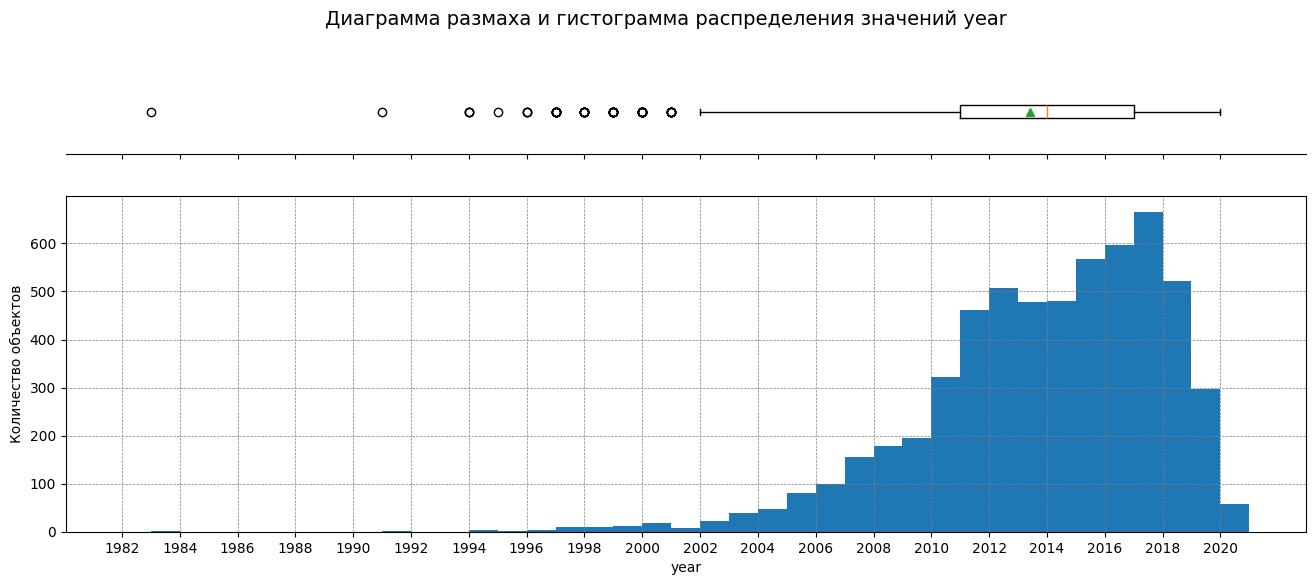

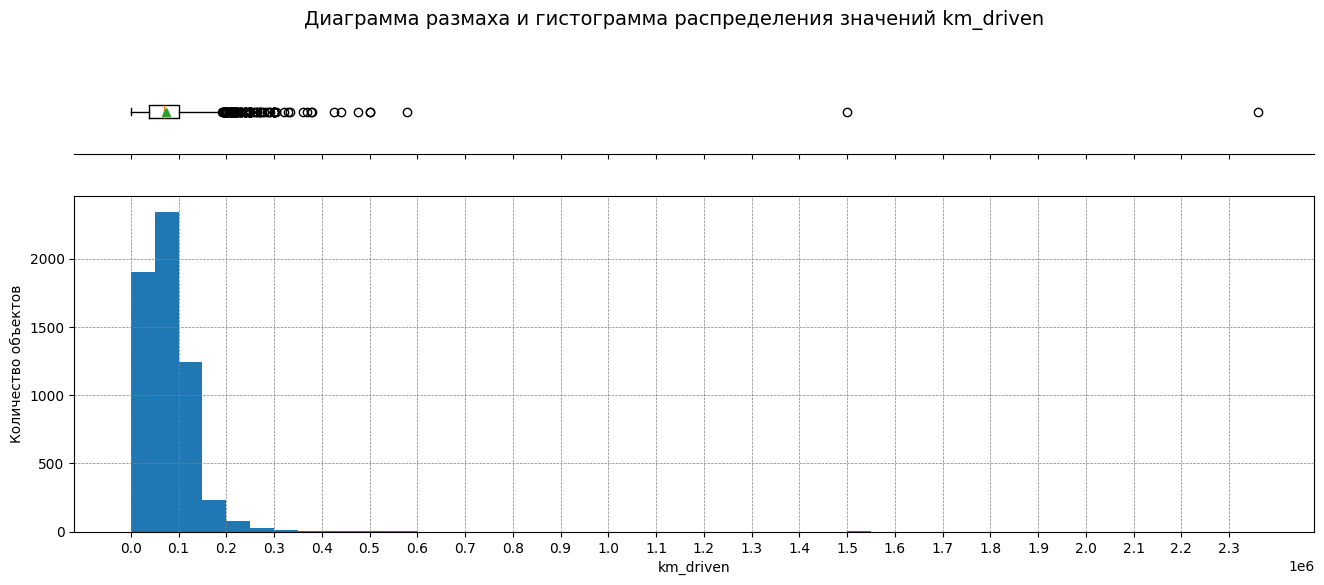

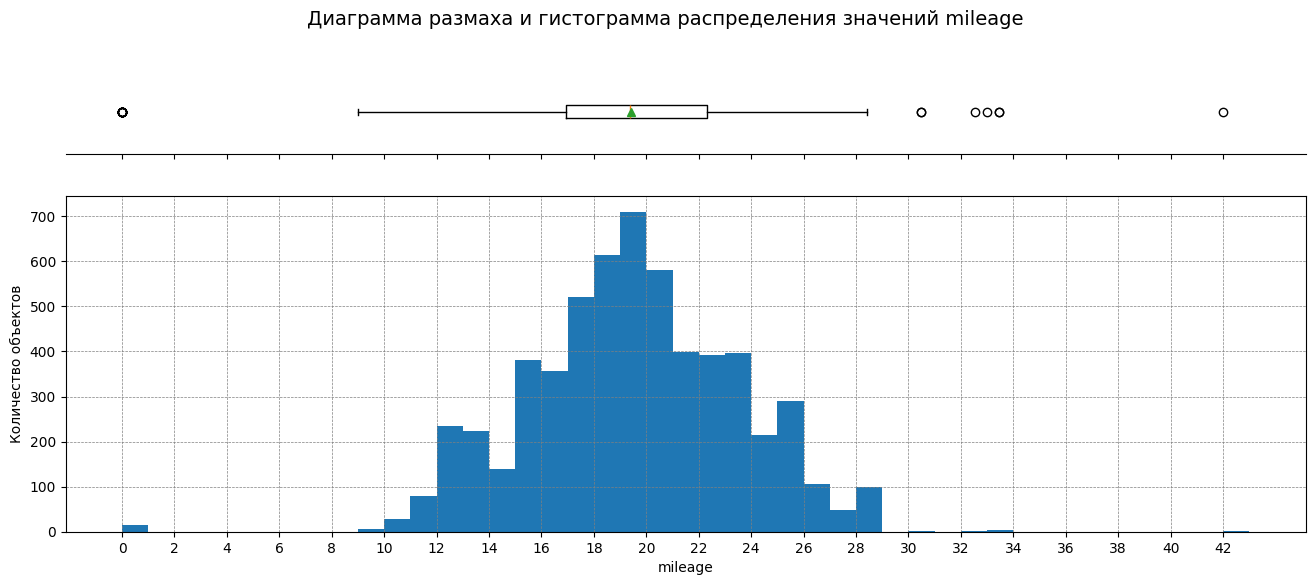

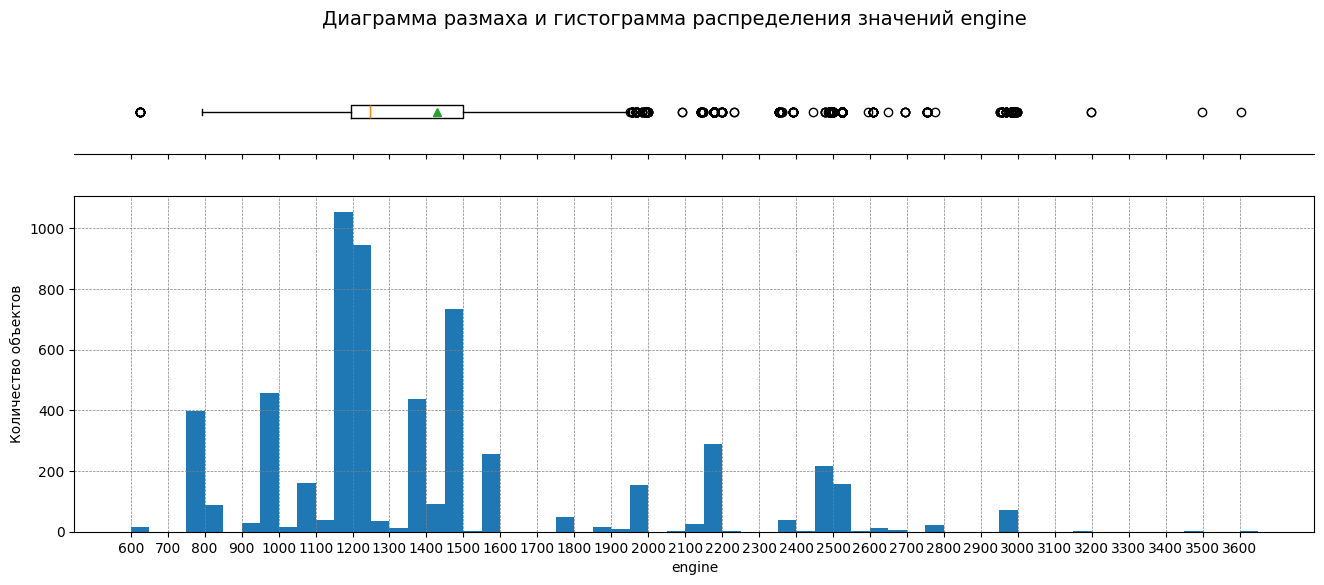

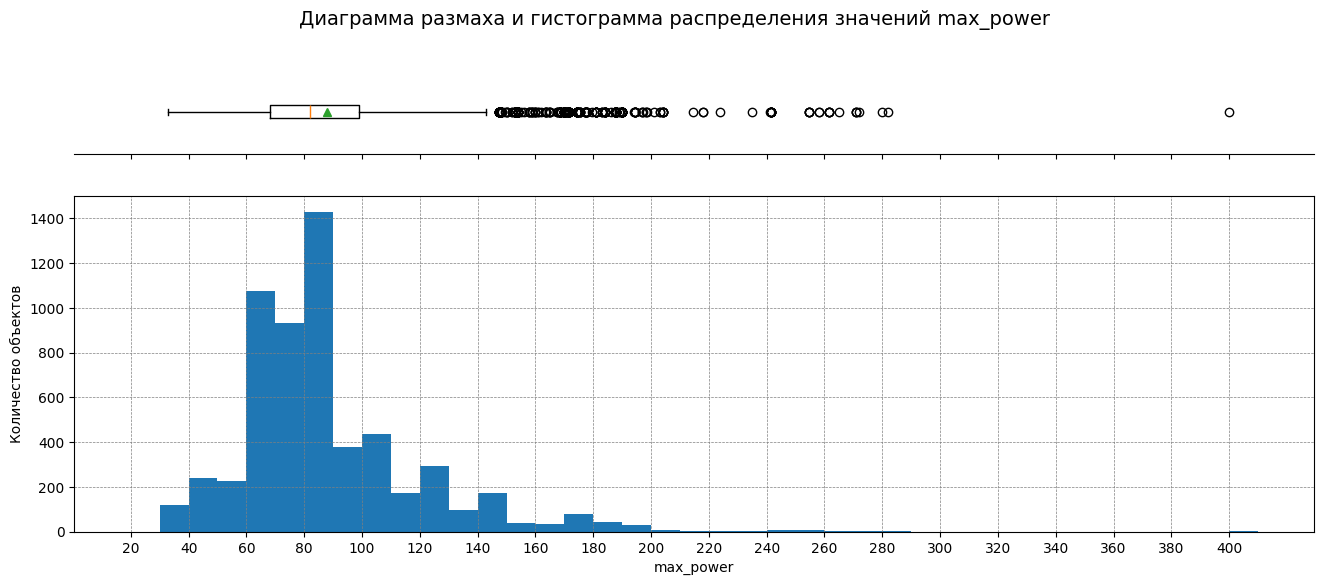

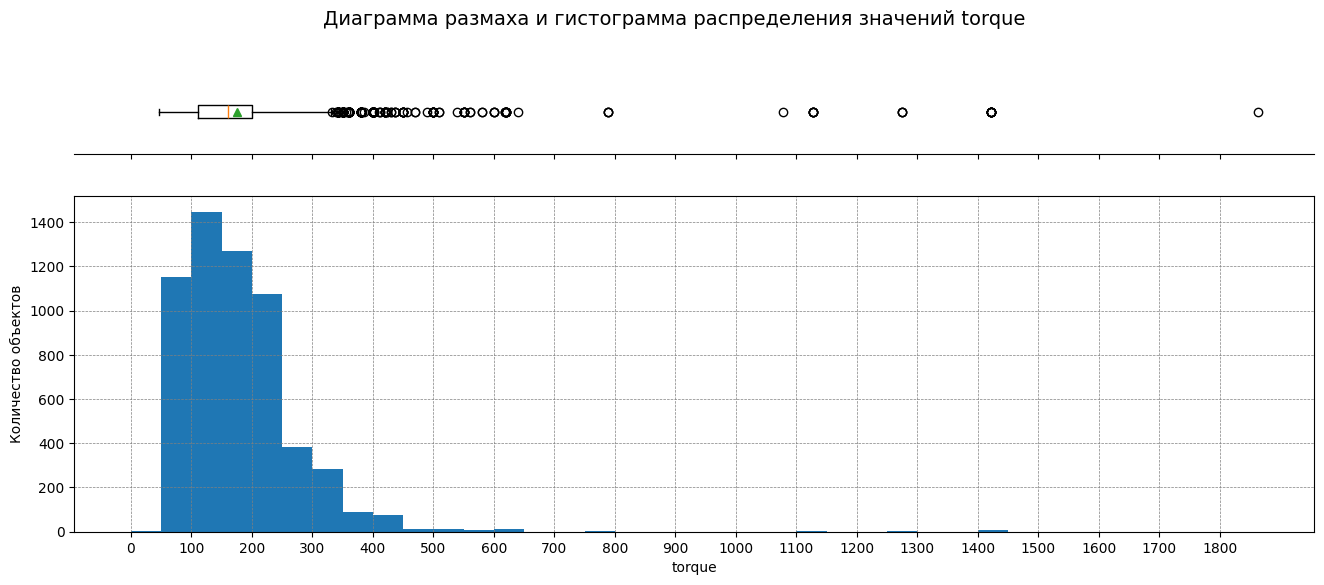

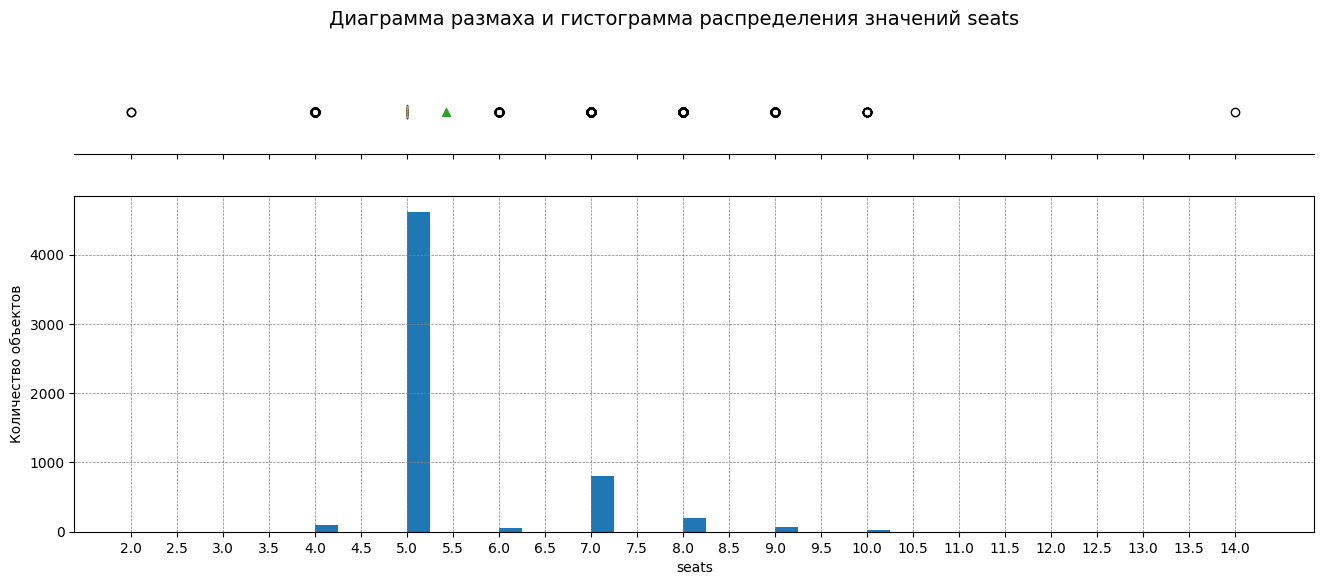

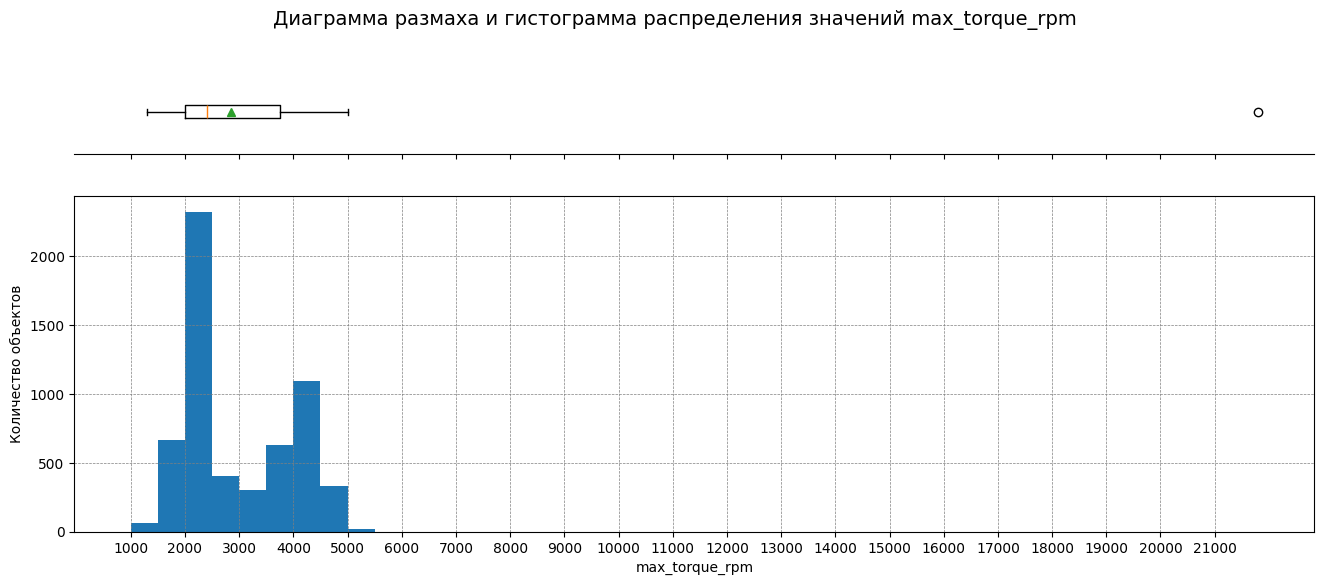

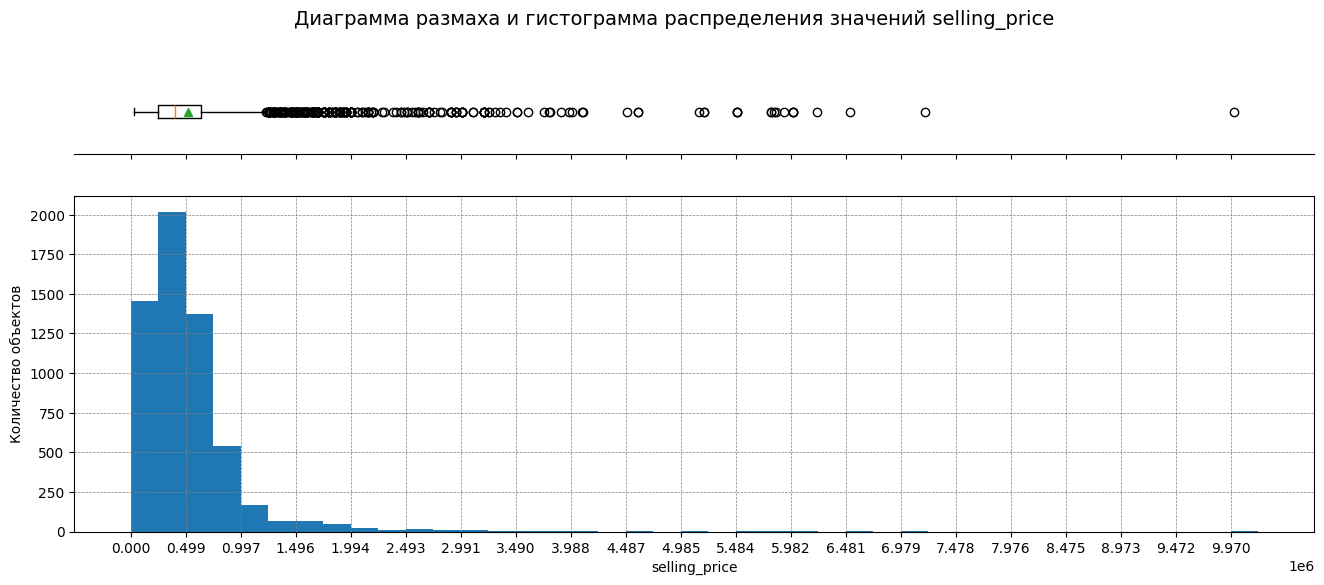

In [97]:
for col in (num_features + ['selling_price']):
    show_feature_distribution(df_train[col])

Избавимся от выбросовв обучающей выборке, которые выглядят аномальными в рамках имеющегося датасета, без которых, вероятно, модель будет обучаться лучше:
- признак `year`. Уберём все объекты с годом менее 1994;
- признак `km_driven`. Уберём все объекты с пробегом более 600 тыс;
- признак `mileage`. Уберём объект с нулевым значением, а также объекты со значениями более 35;
- признак `max_power`. Уберём все объекты с мощностью более 300;
- признак `torque`. Уберём все объекты с моментом более 700;
- признак `max_torque_rpm`. Уберём все объекты с оборотами более 6000;
- целевая переменная `selling_price`. Уберём все объекты с ценой более 3,5 млн.

In [98]:
print(f'Объектов до удаления {df_train.shape[0]}')
df_train = df_train[
    (df_train['year'] >= 1994) &
    (df_train['km_driven'] < 600000) &
    (df_train['mileage'] > 0) &
    (df_train['mileage'] <= 35) &
    (df_train['max_power'] <= 300) &
    (df_train['torque'] <= 700) &
    (df_train['max_torque_rpm'] <= 6000)&
    (df_train['selling_price'] <= 3500000)
].copy()
print(f'Объектов после удаления {df_train.shape[0]}')

Объектов до удаления 5840
Объектов после удаления 5770


## Генерация новых признаков

Добавим два числовых признака:
- число километров на год эксплуатации. Этот признак будет отражать среднюю интенсивность использования автомобиля. Количество лет эксплуатации определим по формуле 2020 - year + 1,
- удельная мощность на 1 куб см двигателя. Этот показатель будет определять эфеективность двигателя.

In [99]:
# Километраж в год
df_train['km_per_year'] = df_train['km_driven'] / (2020 - df_train['year'] + 1)

In [100]:
# Удельная мощность на 1 куб см двигателя
df_train['relative_pwr'] = df_train['max_power'] / df_train['engine']

In [101]:
# Обновим список признаков (name не включаем)
X = ['year', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats', 'max_torque_rpm', 'car_make', 'car_model', 'km_per_year',
       'relative_pwr']

In [102]:
# Обновим список числовых переменных
num_features = (
    df_train[X]
    .select_dtypes(include=['int', 'float'])
    .columns.to_list()
)
num_features

['year',
 'km_driven',
 'mileage',
 'engine',
 'max_power',
 'torque',
 'seats',
 'max_torque_rpm',
 'km_per_year',
 'relative_pwr']

## Анализ связи с целевым признаком

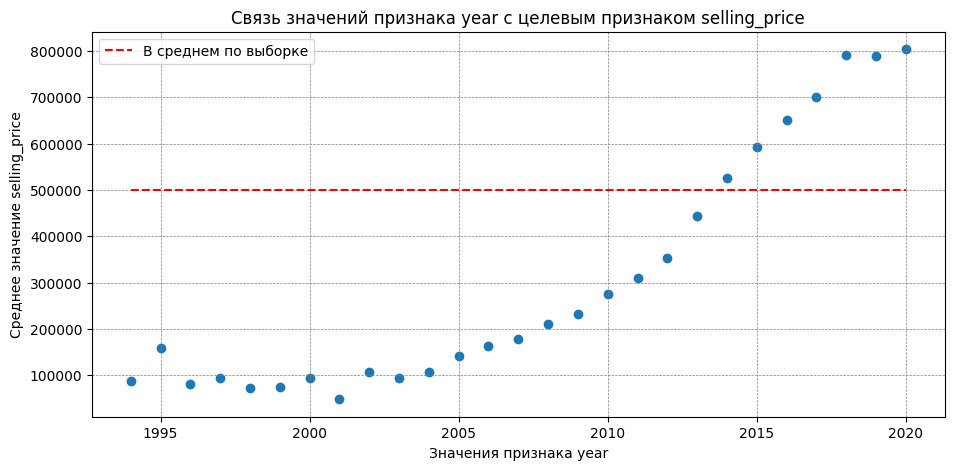

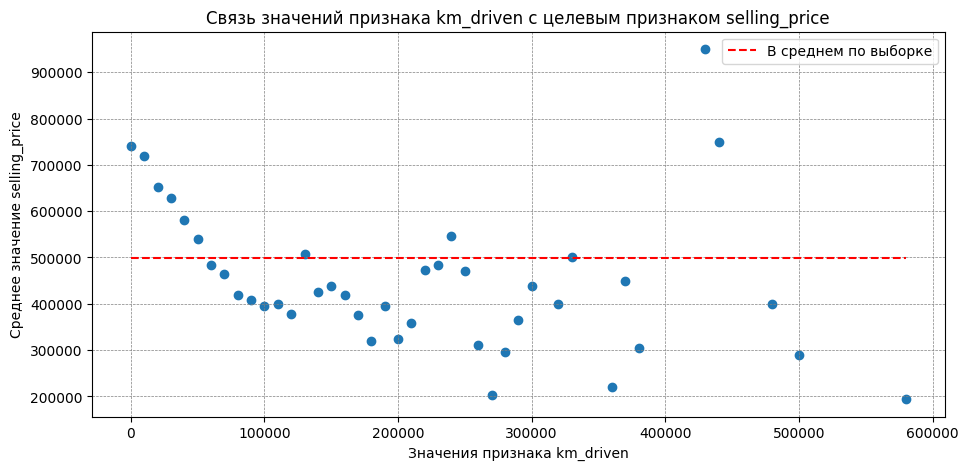

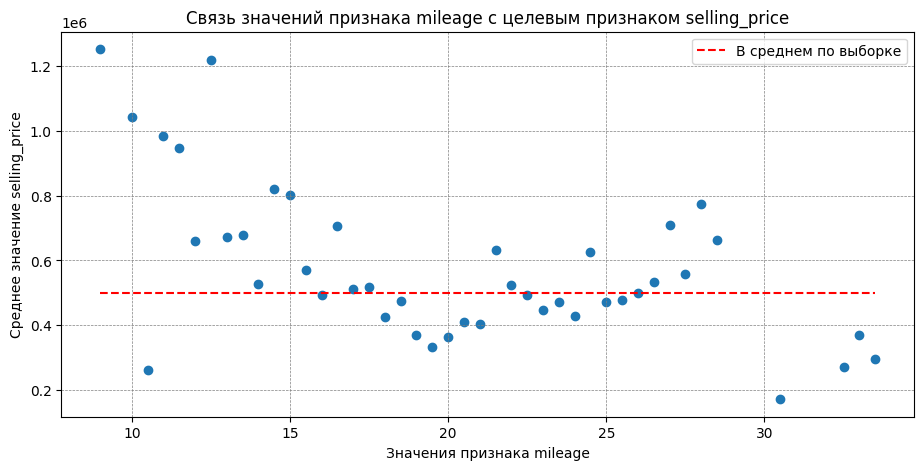

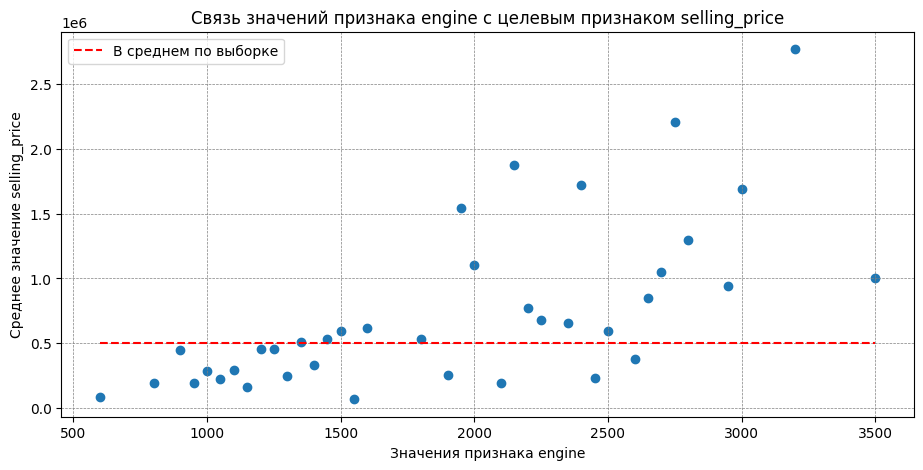

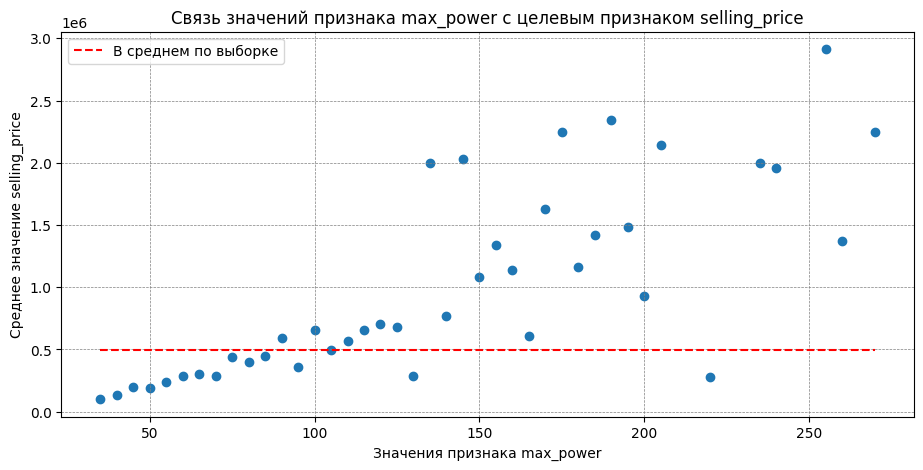

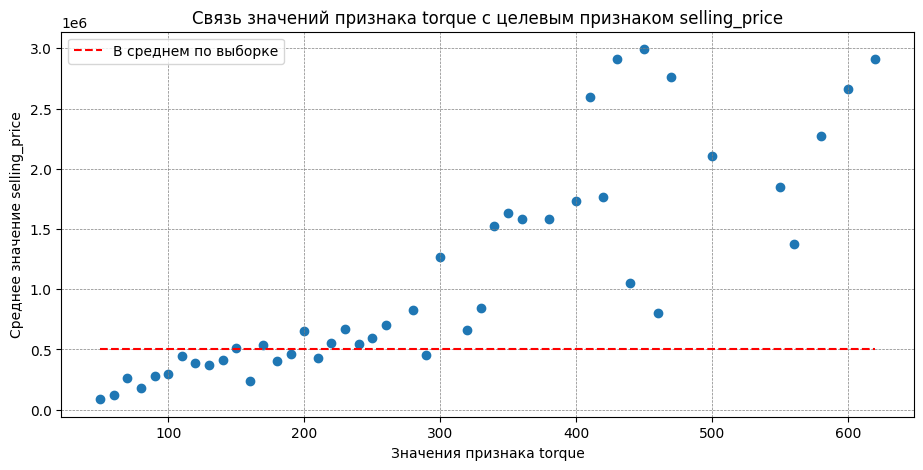

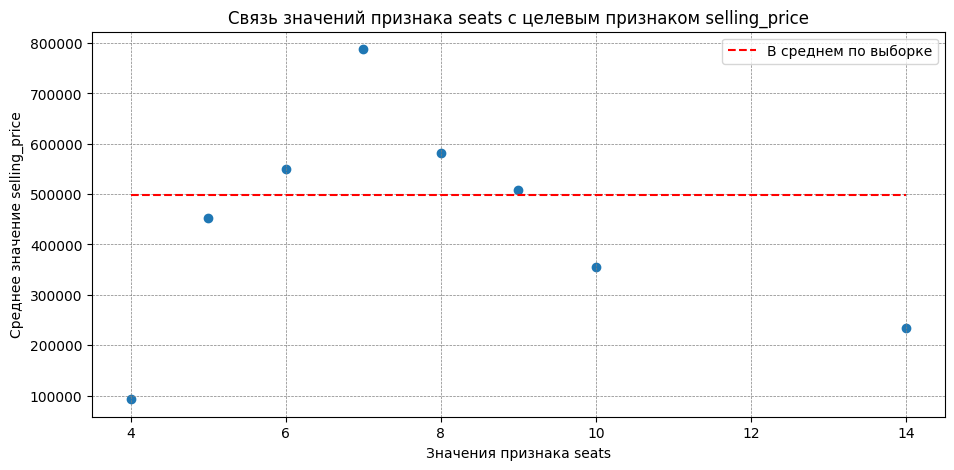

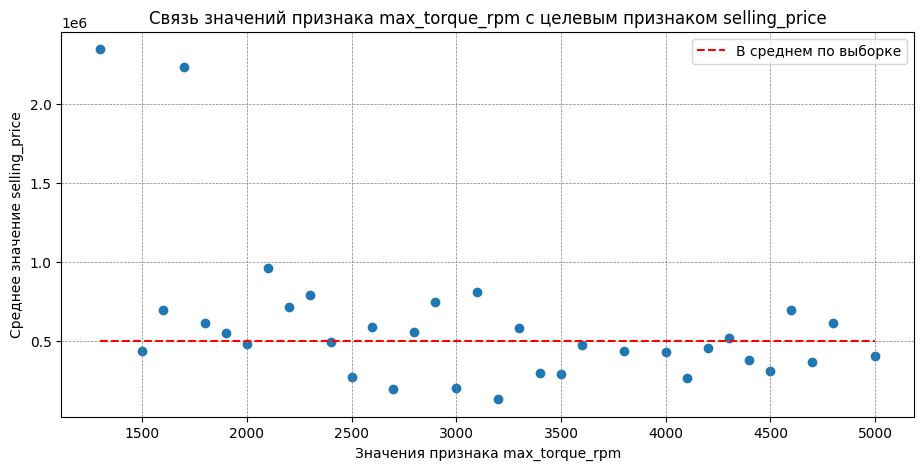

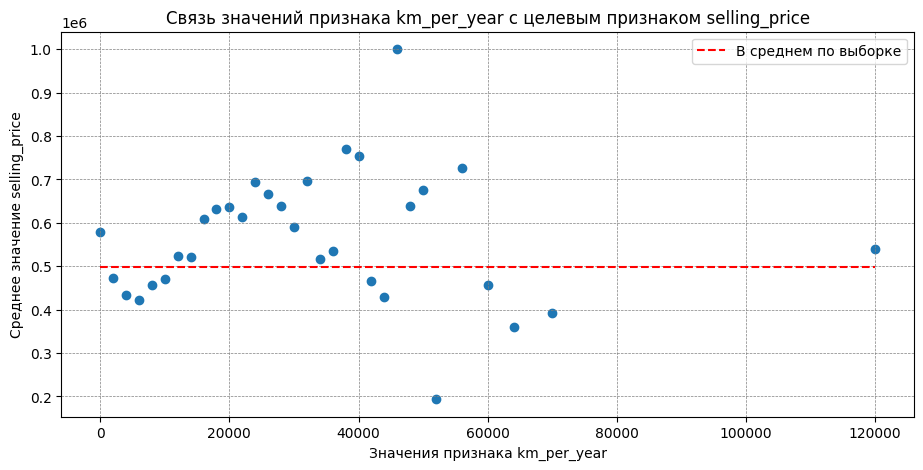

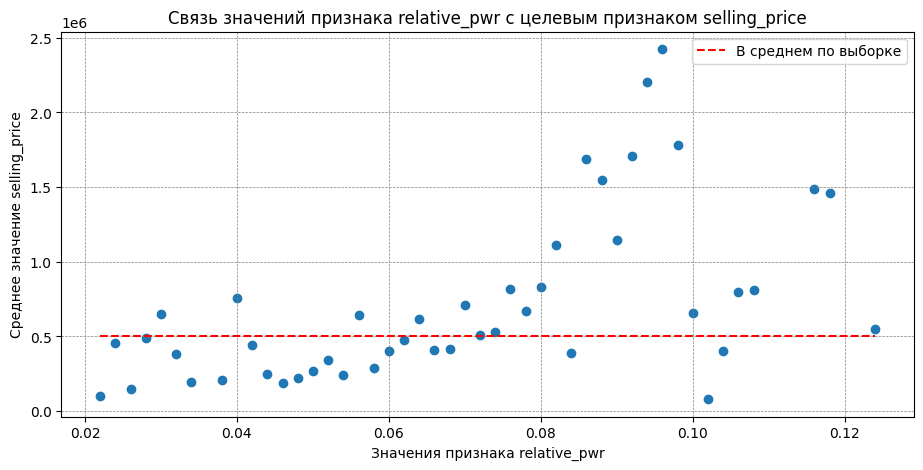

In [103]:
# Построим графики зависимости цены от числовых признаков
for col in num_features:
  show_target_dependence(dataset=df_train,
                         factor=col,
                         target='selling_price',
                         is_cat=False)

Видим, что зависимость от года похожа на квадратичную. Добавим признак год в квадрате.

In [104]:
df_train['year_pow2'] = df_train['year'] ** 2

In [105]:
# Аналогичные признаки добавим в тестовую выборку
df_test['km_per_year'] = df_test['km_driven'] / (2020 - df_test['year'] + 1)
df_test['relative_pwr'] = df_test['max_power'] / df_test['engine']
df_test['year_pow2'] = df_test['year'] ** 2

## Моделирование с новыми признаками без выбросов

In [106]:
# Обновим список признаков (name не включаем)
X = ['year', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats', 'max_torque_rpm', 'car_make', 'car_model', 'km_per_year',
       'relative_pwr', 'year_pow2']

In [107]:
# Обновим список числовых переменных
num_features = (
    df_train[X]
    .select_dtypes(include=['int', 'float'])
    .columns.to_list()
)
num_features

['year',
 'km_driven',
 'mileage',
 'engine',
 'max_power',
 'torque',
 'seats',
 'max_torque_rpm',
 'km_per_year',
 'relative_pwr',
 'year_pow2']

In [108]:
# Обновим список категориальных признаков
cat_features = df_train[X].select_dtypes(include='object').columns.to_list()
cat_features

['fuel', 'seller_type', 'transmission', 'owner', 'car_make', 'car_model']

In [109]:
# Обновим набор преобразований столбцов
col_transformer = make_column_transformer(
    (
        OneHotEncoder(handle_unknown='ignore',
                      drop='first',
                      dtype='int16',
                      sparse_output=False),
        cat_features
    ),
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=True
)

In [110]:
# Создадим переменные с данными для модели, не забыв про удаление
# лишних объектов в таргете на трейне
X_train_extended = df_train[X].copy()
y_train_extended = y_train[df_train.index]
X_test_extended = df_test[X].copy()

In [111]:
# Пайплайн обработки данных и обучения модели ElastiNet
elnet_pl_ext = make_pipeline(col_transformer, ElasticNet())

param_grid_elnet = {
    'elasticnet__alpha': np.linspace(1, 50000, 20),
    'elasticnet__l1_ratio': np.linspace(0.01, 1, 10),
}
gs_elnet_pl_ext = GridSearchCV(
                           elnet_pl_ext,
                           param_grid=param_grid_elnet,
                           scoring='r2',
                           cv=10,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_elnet_pl_ext.fit(X_train_extended, y_train_extended)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_elnet_pl_ext.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_elnet_pl_ext.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_elnet_pl_ext.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_elnet_pl_ext.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_elnet_pl_ext.best_estimator_,
                    'gs_elnet_pl_ext.pkl',
                    compress=0)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
best_score: 0.8112838308721543
best_params: {'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 1.0}
Changed directory for model to current directory


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.810e+13, tolerance: 9.311e+10
  model = cd_fast.enet_coordinate_descent(


In [112]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train_extended, gs_elnet_pl_ext.best_estimator_.predict(X_train_extended))}')
print(f'MSE {MSE(y_train_extended, gs_elnet_pl_ext.best_estimator_.predict(X_train_extended))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_elnet_pl_ext.best_estimator_.predict(X_test_extended))}')
print(f'MSE {MSE(y_test, gs_elnet_pl_ext.best_estimator_.predict(X_test_extended))}')

Обучающая выборка
R2 0.8696450240790833
MSE 21035279793.409325
Тестовая выборка
R2 0.6243287542731549
MSE 215946559576.05746


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [113]:
# Пайплайн обработки данных и обучения линейной модели
ridge_pl_ext = make_pipeline(col_transformer, Ridge())

param_grid_ridge = {
    'ridge__alpha': np.linspace(1, 50000, 100)
}
gs_ridge_pl_ext = GridSearchCV(
                           ridge_pl_ext,
                           param_grid=param_grid_ridge,
                           scoring='r2',
                           cv=10,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_ridge_pl_ext.fit(X_train_extended, y_train_extended)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_ridge_pl_ext.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_ridge_pl_ext.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_ridge_pl_ext.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_ridge_pl_ext.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_ridge_pl_ext.best_estimator_,
                    'gs_ridge_pl_ext.pkl',
                    compress=0)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
best_score: 0.8192553956974702
best_params: {'ridge__alpha': 1.0}
Changed directory for model to current directory


In [114]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train_extended, gs_ridge_pl_ext.best_estimator_.predict(X_train_extended))}')
print(f'MSE {MSE(y_train_extended, gs_ridge_pl_ext.best_estimator_.predict(X_train_extended))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_ridge_pl_ext.best_estimator_.predict(X_test_extended))}')
print(f'MSE {MSE(y_test, gs_ridge_pl_ext.best_estimator_.predict(X_test_extended))}')

Обучающая выборка
R2 0.8646820284609223
MSE 21836154487.328297
Тестовая выборка
R2 0.6348959774336119
MSE 209872217949.62283


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Удалось ещё улучшить качество модели.

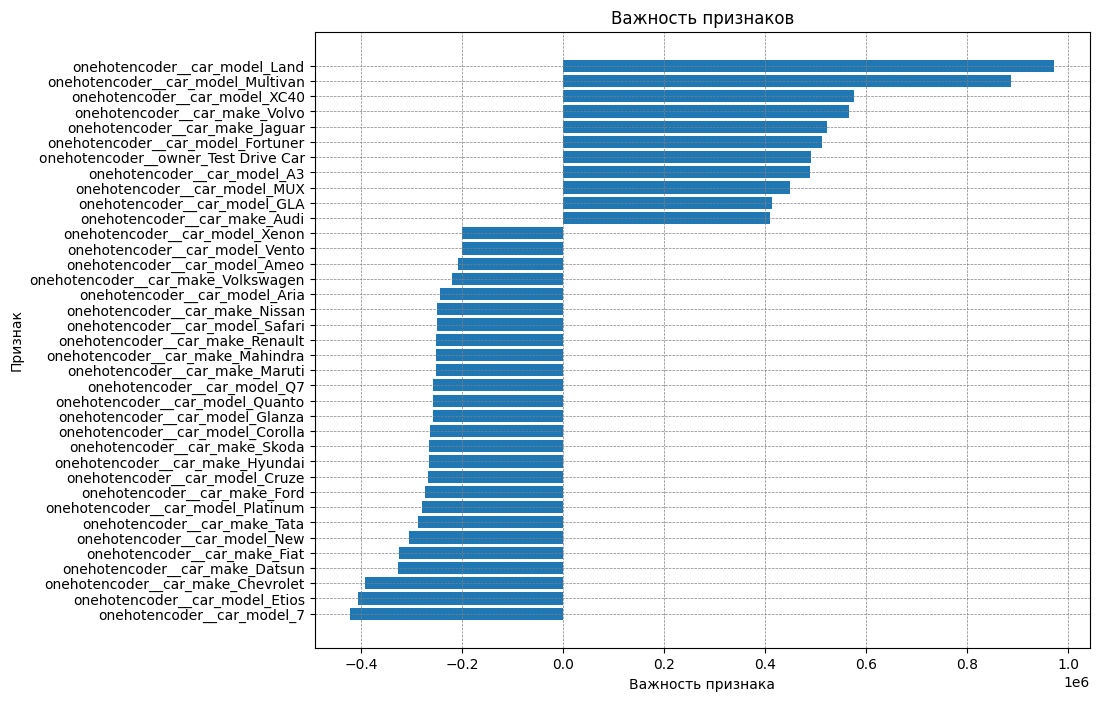

In [115]:
# Проверим важность признаков с точки зрения модели
importances = gs_ridge_pl_ext.best_estimator_['ridge'].coef_
importances = pd.Series(
    importances,
    index=gs_ridge_pl_ext.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[(importances>0.4e6)|(importances<-0.2e6)]
# Построим диаграмму для наглядности
plt.figure(figsize=(10, 8))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [x] Реализуйте метрику `business_metric`
- [x] Посчитайте метрику для всех обученных моделей и определеите, какая лучше всего решает задачу бизнеса

In [116]:
def business_metrics(y_true, y_pred):
    deviations = np.abs(y_pred - y_true) / y_true

    return (deviations <= 0.1).mean()

In [117]:
# Вычислим метрику у обученных моделей
print('Обучающая выборка')
print(f'{"business_metrics (LinearRegression numeric)":<55} {business_metrics(y_train, lr_num.predict(X_train_num)):.10}')
print(f'{"business_metrics (LinearRegression numeric scaled)":<55} {business_metrics(y_train, lr_num_scaled.predict(X_train_num_scaled)):.10}')
print(f'{"business_metrics (Lasso numeric scaled)":<55} {business_metrics(y_train, gs_lasso_pl.best_estimator_.predict(X_train_num)):.10}')
print(f'{"business_metrics (ElasticNet numeric scaled)":<55} {business_metrics(y_train, gs_elnet_pl.best_estimator_.predict(X_train_num)):.10}')
print(f'{"business_metrics (ElasticNet extended)":<55} {business_metrics(y_train_extended, gs_elnet_pl_ext.best_estimator_.predict(X_train_extended)):.10}')
print(f'{"business_metrics (Ridge)":<55} {business_metrics(y_train, gs_ridge_pl.best_estimator_.predict(X_train_cat)):.10}')
print(f'{"business_metrics (Ridge extended)":<55} {business_metrics(y_train_extended, gs_ridge_pl_ext.best_estimator_.predict(X_train_extended)):.10}')
print()
print('Тестовая выборка')
print(f'{"business_metrics (LinearRegression numeric)":<55} {business_metrics(y_test, lr_num.predict(X_test_num)):.10}')
print(f'{"business_metrics (LinearRegression numeric scaled)":<55} {business_metrics(y_test, lr_num_scaled.predict(X_test_num_scaled)):.10}')
print(f'{"business_metrics (Lasso numeric scaled)":<55} {business_metrics(y_test, gs_lasso_pl.best_estimator_.predict(X_test_num)):.10}')
print(f'{"business_metrics (ElasticNet numeric scaled)":<55} {business_metrics(y_test, gs_elnet_pl.best_estimator_.predict(X_test_num)):.10}')
print(f'{"business_metrics (ElasticNet extended)":<55} {business_metrics(y_test, gs_elnet_pl_ext.best_estimator_.predict(X_test_extended)):.10}')
print(f'{"business_metrics (Ridge)":<55} {business_metrics(y_test, gs_ridge_pl.best_estimator_.predict(X_test_cat)):.10}')
print(f'{"business_metrics (Ridge extended)":<55} {business_metrics(y_test, gs_ridge_pl_ext.best_estimator_.predict(X_test_extended)):.10}')

Обучающая выборка
business_metrics (LinearRegression numeric)             0.2174657534
business_metrics (LinearRegression numeric scaled)      0.2174657534
business_metrics (Lasso numeric scaled)                 0.2258561644
business_metrics (ElasticNet numeric scaled)            0.2258561644
business_metrics (ElasticNet extended)                  0.3462738302
business_metrics (Ridge)                                0.3224315068
business_metrics (Ridge extended)                       0.3343154246

Тестовая выборка
business_metrics (LinearRegression numeric)             0.24
business_metrics (LinearRegression numeric scaled)      0.24
business_metrics (Lasso numeric scaled)                 0.244
business_metrics (ElasticNet numeric scaled)            0.244
business_metrics (ElasticNet extended)                  0.339
business_metrics (Ridge)                                0.35
business_metrics (Ridge extended)                       0.34


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Для более точного ответа необходимо прогнать модели через кроссвалидацию с новой кастомной метрикой. Если судить по метрикам на обучающей и тестовой выборках, то лучше всего задачу бизнеса решала бы модель ElasticNet или Ridge на расширенном датасете с удалёнными выбросами, либо Ridge на датасете с числовыми и категориальными признаками без удаления выбросов и без дополнительных признаков.

### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [x] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [x] Посчитайте метрику для всех обученных моделей и определите, какая лучше всего решает задачу бизнеса



Возьмём в качестве метрики модифицированную созданную ранее функцию. Для ошибок недопрогноза и перепрогноза будем учитывать разные заданные доли:
- по недопрогнозов under_est,
- по перепрогнозам over_est.  
Т.е. среди всех предсказанных цен на авто посчитаем долю прогнозов, отличающихся от реальных цен на эти авто не более чем на `under_est`% в сторону уменьшения и не более чем на `over_est`% в сторону увеличения.

In [118]:
def your_business_metrics(y_true, y_pred, under_est=0.02, over_est=0.18):
    deviations = (y_pred - y_true) / y_true

    result = (((deviations <= over_est) & (deviations > 1)).sum() +
              ((deviations >= under_est) & (deviations < 1)).sum()) / len(y_true)

    return result

In [119]:
# Вычислим метрику у обученных моделей
print('Обучающая выборка')
print(f'{"your_business_metrics (LinearRegression numeric)":<50} {your_business_metrics(y_train, lr_num.predict(X_train_num)):.10}')
print(f'{"your_business_metrics (LinearRegression numeric scaled)":<50} {your_business_metrics(y_train, lr_num_scaled.predict(X_train_num_scaled)):.10}')
print(f'{"your_business_metrics (Lasso numeric scaled)":<50} {your_business_metrics(y_train, gs_lasso_pl.best_estimator_.predict(X_train_num)):.10}')
print(f'{"your_business_metrics (ElasticNet numeric scaled)":<50} {your_business_metrics(y_train, gs_elnet_pl.best_estimator_.predict(X_train_num)):.10}')
print(f'{"your_business_metrics (ElasticNet extended)":<50} {your_business_metrics(y_train_extended, gs_elnet_pl_ext.best_estimator_.predict(X_train_extended)):.10}')
print(f'{"your_business_metrics (Ridge)":<50} {your_business_metrics(y_train, gs_ridge_pl.best_estimator_.predict(X_train_cat)):.10}')
print(f'{"your_business_metrics (Ridge extended)":<50} {your_business_metrics(y_train_extended, gs_ridge_pl_ext.best_estimator_.predict(X_train_extended)):.10}')
print()
print('Тестовая выборка')
print(f'{"your_business_metrics (LinearRegression numeric)":<50} {your_business_metrics(y_test, lr_num.predict(X_test_num)):.10}')
print(f'{"your_business_metrics (LinearRegression numeric scaled)":<50} {your_business_metrics(y_test, lr_num_scaled.predict(X_test_num_scaled)):.10}')
print(f'{"your_business_metrics (Lasso numeric scaled)":<50} {your_business_metrics(y_test, gs_lasso_pl.best_estimator_.predict(X_test_num)):.10}')
print(f'{"your_business_metrics (ElasticNet numeric scaled)":<50} {your_business_metrics(y_test, gs_elnet_pl.best_estimator_.predict(X_test_num)):.10}')
print(f'{"your_business_metrics (ElasticNet extended)":<50} {your_business_metrics(y_test, gs_elnet_pl_ext.best_estimator_.predict(X_test_extended)):.10}')
print(f'{"your_business_metrics (Ridge)":<50} {your_business_metrics(y_test, gs_ridge_pl.best_estimator_.predict(X_test_cat)):.10}')
print(f'{"your_business_metrics (Ridge extended)":<50} {your_business_metrics(y_test, gs_ridge_pl_ext.best_estimator_.predict(X_test_extended)):.10}')

Обучающая выборка
your_business_metrics (LinearRegression numeric)   0.4436643836
your_business_metrics (LinearRegression numeric scaled) 0.4436643836
your_business_metrics (Lasso numeric scaled)       0.4431506849
your_business_metrics (ElasticNet numeric scaled)  0.4431506849
your_business_metrics (ElasticNet extended)        0.4679376083
your_business_metrics (Ridge)                      0.4702054795
your_business_metrics (Ridge extended)             0.4741767764

Тестовая выборка
your_business_metrics (LinearRegression numeric)   0.428
your_business_metrics (LinearRegression numeric scaled) 0.428
your_business_metrics (Lasso numeric scaled)       0.439
your_business_metrics (ElasticNet numeric scaled)  0.439
your_business_metrics (ElasticNet extended)        0.46
your_business_metrics (Ridge)                      0.475
your_business_metrics (Ridge extended)             0.469


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Здесь также с небольшой разницей лучшие результаты у тех же моделей.

# **Часть 5 (3 балла) | Реализация сервиса на FastAPI**

### **Задание 25**

Cделайте с помощью FastAPI сервис, который с точки зрения пользователя реализует две функции:

1. на вход в формате json подаются признаки одного объекта, на выходе сервис выдает предсказанную стоимость машины
2. на вход подается csv-файл с признаками тестовых объектов, на выходе получаем файл с +1 столбцом - предсказаниями на этих объектах

С точки зрения реализации это означает следующее:
- средствами pydantic должен быть описан класс базового объекта
- класс с коллецией объектов
- метод post, который получает на вход один объект описанного класса
- метод post, который получает на вход коллекцию объектов описанного класса

Шаблон для сервисной части дан ниже. Код необходимо дополнить и оформить в виде отдельного .py-файла.

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List

app = FastAPI()


class Item(BaseModel):
    name: str
    year: int
    selling_price: int
    km_driven: int
    fuel: str
    seller_type: str
    transmission: str
    owner: str
    mileage: str
    engine: str
    max_power: str
    torque: str
    seats: float


class Items(BaseModel):
    objects: List[Item]


@app.post("/predict_item")
def predict_item(item: Item) -> float:
    return ...


@app.post("/predict_items")
def predict_items(items: List[Item]) -> List[float]:
    return ...

Протестируйте сервис на корректность работы и приложите скриншоты (см. ниже).

# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 26**

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Под результатами понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.py``-файл с реализацией сервиса
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

**Как будет выглядет проверка всего домашнего задания?**
1. Ассистент проходит по ссылке на (**открытый**) репозиторий из Энитаска
2. Смотрит ``readme.md``:
    * пожалуйста, приложите в него же скрины работы вашего сервиса -- собирать ваши проекты довольно времязатратно, но хочется убедиться, что всё работает
    * можете в md-файл приложить ссылку на screencast с демонстрацией

3. Просматривает ноутбук с DS частью
4. Заглядывает в код сервиса
5. Хвалит

# **Часть Благодарственная**

Надеемся, вы честно проделали все пункты, а не просто пролистали досюда. Потому что здесь награда за старания. Пожалуйста, не стоит награждать себя до того, как закончите работать над домашкой.

<details>
<summary><b>Что-то приятное</b></summary>

**Напоминаем, что нашем курсе действует система кото-бонусов** 🐈

На фото по ссылке — сэр кот кого-то из команды курса (преподаватель, помощник преподавателя, ассистенты).

Предлагаем вам угадать — чей это товарищ!

[Первый кот](https://ibb.co/Kz1ZRWj)

</details>